# Recracking the Coding Interview
Rohit Das, Vinnie Khanna, Raj Srivastava, Pranay Agrawal

## Imports

In [ ]:
%%bash
pip install tqdm transformers eli5 wordcloud datasets

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory



In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
import imblearn
from tqdm import tqdm
import transformers
import matplotlib.pyplot as plt
from matplotlib.axes import Axes as ax
% matplotlib inline

import heapq as hq
from wordcloud import WordCloud

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn import decomposition
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OneHotEncoder

### Drive Mounting

In [ ]:
### Toggle True or False for Colab or Git Environment
COLABMODE = True

In [ ]:
from google.colab import drive
if COLABMODE:
   drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%ls
%cd drive/MyDrive/CS4650

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
bert_attention_half.pt            friends_subtitles.pkl
bert_attention_other_half.pt      pddf_model_epoch13.pt
bert_embeddings_half.pt           pd_model.pt
bert_embeddings_other_half.pt     problem_data_codeforces.csv
bert_embeddings.pt                problem_data_lc.csv
cf_metadata.txt                   results/
cleaned_data_codeforces.csv       runtime_metadata.txt
cleaned_data_combined.csv         runtime_train_data.csv
cleaned_data_lc.csv               runtime_val_data.csv
df_model.pt                       top10runtimes.png
difficulties.png                  top10tags.png
final_difficulty_df_combined.csv  upsampled_labels_half.pt
final_runtime_df_lc.csv           upsampled_labels_other_half.pt
final_topics_df_combined.csv


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-82-03e18c3ed0b2>", line 2, in <module>
    get_ipython().magic('cd drive/MyDrive/CS4650')
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2160, in magic
    return self.run_line_magic(magic_name, magic_arg_s)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2081, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-84>", line 2, in cd
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/magic.py", line 188, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/magics/osm.py", line 288, in cd
    oldcwd = py3compat.getcwd()
FileNotFoundError: [Errno 2] No such file or directory

During handling of the above except

FileNotFoundError: ignored

In [ ]:
### Once scraping is finished, this is how we'll load data
df_lc = pd.read_csv('cleaned_data_lc.csv')
df_cf = pd.read_csv('cleaned_data_codeforces.csv')
df_combined = pd.read_csv('cleaned_data_combined.csv')
final_difficulty_df_combined = pd.read_csv('final_difficulty_df_combined.csv')
final_runtime_df_lc = pd.read_csv('final_runtime_df_lc.csv')
final_topics_df_combined = pd.read_csv('final_topics_df_combined.csv')

##Data Processing

### Toy Dataset

In [ ]:
# idx: text, difficulty, category, time complexity
USE_EXAMPLE = False

if USE_EXAMPLE:
  example = {'text': ['Given an array of integers nums and an integer target, return indices of the two numbers such that they add up to target.\
   You may assume that each input would have exactly one solution, and you may not use the same element twice. You can return the answer in any order.',

    'Given two sorted arrays nums1 and nums2 of size m and n respectively, return the median of the two sorted arrays.',

    'You are given two non-empty linked lists representing two non-negative integers. The digits are stored in reverse order, \
    and each of their nodes contains a single digit. Add the two numbers and return the sum as a linked list. \
    You may assume the two numbers do not contain any leading zero, except the number 0 itself.',

    'Given a string s, return the longest palindromic substring in s.',

    'Given an array nums of distinct integers, return all the possible permutations. You can return the answer in any order.'
    ], 
    
    'difficulty': ['Easy', 'Hard', 'Medium', 'Medium', 'Medium'], 
    
    'category': ['hash map', 'binary search', 'linked list', 'dynamic programming', 'backtracking'], 
    
    'time_complexity': ['O(n)', 'O(log(n))', 'O(n)', 'O(n)', 'O(n!)']}
  data = pd.DataFrame(example)

  text = data.text.values
  print(text)

### Data Analysis

#### Difficulty

In [ ]:
pd.set_option('max_colwidth', 25)
print(df_combined.iloc[0], "\n")
print(df_combined.iloc[-2], "\n")

Unnamed: 0                            0
id                                    1
title                           Two Sum
title_slug                      two-sum
difficulty                            1
description    Given an array of int...
topics                Array, Hash Table
runtime                               n
Name: 0, dtype: object 

Unnamed: 0                         8494
id                                  NaN
title                    Game of Chance
title_slug                          NaN
difficulty                         3500
description    The King wants to mar...
topics              math, probabilities
runtime                             NaN
Name: 8494, dtype: object 



In [ ]:
count_lc = {1:0, 2:0, 3:0}
for i in range(len(df_lc)):
  count_lc[df_lc.iloc[i]['difficulty']] += 1
print("Leetcode difficulties: ", count_lc, "\n")
count_cf = {1:0, 2:0, 3:0}
for i in range(len(df_cf)):
  difficulty = df_cf.iloc[i]['difficulty']
  count_cf[1 if difficulty <= 1300 else 2 if difficulty > 1300 and difficulty <= 1800 else 3] += 1
print("Codeforces difficulties: ", count_cf, "\n")

count = {1:0, 2:0, 3:0}
for i in range(1, 4, 1):
  count[i] = count_lc[i] + count_cf[i]

print("Total difficulties: ", count)

Leetcode difficulties:  {1: 392, 2: 826, 3: 350} 

Codeforces difficulties:  {1: 1727, 2: 1736, 3: 3465} 

Total difficulties:  {1: 2119, 2: 2562, 3: 3815}


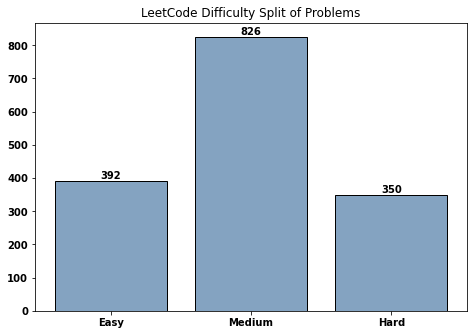

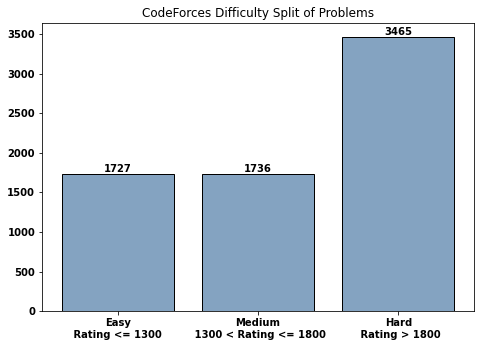

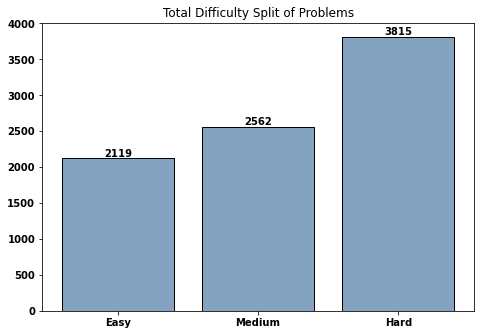

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
difficulty = ["Easy", "Medium", "Hard"]
counts = []
for i in count:
  counts.append(count_lc[i])
bars1 = ax.bar(difficulty,counts,color=(0.2, 0.4, 0.6, 0.6),edgecolor='black')
ax.set_title("LeetCode Difficulty Split of Problems")
for bar in bars1: #labels
  x_pos = bar.get_x() + bar.get_width() / 2
  height = bar.get_height()
  ax.text(x_pos, height + .25, s=round(height,3), ha='center', va='bottom')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
difficulty = ["Easy\n Rating <= 1300 ", "Medium\n 1300 < Rating <= 1800", "Hard\n Rating > 1800"]
counts = []
for i in count:
  counts.append(count_cf[i])
bars2 = ax.bar(difficulty,counts,color=(0.2, 0.4, 0.6, 0.6),edgecolor='black')
ax.set_title("CodeForces Difficulty Split of Problems")
for bar in bars2: #labels
  x_pos = bar.get_x() + bar.get_width() / 2
  height = bar.get_height()
  ax.text(x_pos, height + .25, s=round(height,3), ha='center', va='bottom')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
difficulty = ["Easy", "Medium", "Hard"]
counts = []
for i in count:
  counts.append(count[i])
bars3 = ax.bar(difficulty,counts,color=(0.2, 0.4, 0.6, 0.6),edgecolor='black')
ax.set_title("Total Difficulty Split of Problems")
for bar in bars3: #labels
  x_pos = bar.get_x() + bar.get_width() / 2
  height = bar.get_height()
  ax.text(x_pos, height + .25, s=round(height,3), ha='center', va='bottom')
plt.show()

#### Titles

In [ ]:
bow = {}
for i in range(len(df_combined)):
  for word in df_combined.iloc[i]['title'].split(' '):
    if word not in bow:
      bow[word] = 1
    else:
      bow[word]+=1

In [ ]:
freq = []
for i in bow:
  hq.heappush(freq, (bow[i], i))

print(hq.nlargest(20, freq))
print(hq.nsmallest(4, freq))

[(1390, 'and'), (613, 'of'), (406, 'the'), (326, 'a'), (261, 'Number'), (248, 'in'), (239, 'Array'), (235, 'The'), (233, 'Tree'), (220, 'to'), (197, 'Game'), (188, 'String'), (176, 'Sum'), (162, 'Maximum'), (157, 'Two'), (147, 'Binary'), (145, 'Minimum'), (126, 'Numbers'), (107, 'Problem'), (105, 'version)')]
[(1, '!='), (1, '"Or"'), (1, '#NAME?'), (1, '&amp;')]


<Figure size 5760x7200 with 0 Axes>

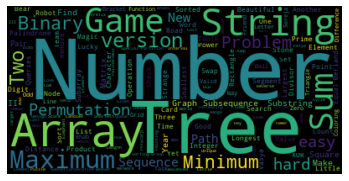

<Figure size 5760x7200 with 0 Axes>

In [ ]:
text = ''
for i in bow:
  for j in range(bow[i]):
    text+=(" " + i)
word_cloud = WordCloud(collocations=False).generate(text)
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.figure(figsize=[80,100])


#### Problem Description

[(87482, 'the'), (47574, 'of'), (34574, 'to'), (28856, 'is'), (28246, 'a'), (25962, 'and'), (18572, 'in'), (16201, 'that'), (14391, 'are'), (14139, ''), (9021, 'number'), (8611, 'can'), (8547, 'from'), (8342, 'be'), (7756, 'with'), (7445, 'one'), (7209, 'if'), (6932, 'each'), (6873, 'he'), (6855, 'for')]
Average Length of Problem Descriptions for df_combined (in words): 157.7735404896422


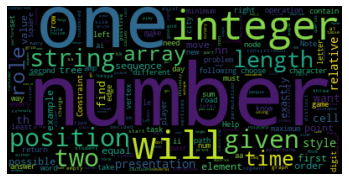

<Figure size 5760x7200 with 0 Axes>

In [ ]:
bow = {}
total_words = 0
for i in range(len(df_combined)):
  total_words += len(df_combined.iloc[i]['description'].split(' '))
  for word in df_combined.iloc[i]['description'].split(' '):
    if word not in bow:
      bow[word] = 1
    else:
      bow[word]+=1
avg_words = total_words/len(df_combined)
freq = []
for i in bow:
  hq.heappush(freq, (bow[i], i))

print(hq.nlargest(20, freq))

text = ''
for i in bow:
  for j in range(bow[i]):
    text+=(" " + i)
word_cloud = WordCloud(collocations=False).generate(text)
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.figure(figsize=[80,100])

print("Average Length of Problem Descriptions for df_combined (in words):", avg_words)

#### Problem Topics

In [ ]:
# Create map of unique topics and their frequencies

###unique_topics = df_combined['topics'].unique()
unique_topic_count = {}
###for entry in unique_topics:
for i in range(len(df_combined)):
  entry = df_combined.iloc[i]['topics']
  if isinstance(entry, str):
    topics = entry.split(', ')
    for topic in topics:
      if topic[0] == ' ':
        if topic[1:] in unique_topic_count:
          unique_topic_count[topic[1:].lower()] += 1
        else:
          unique_topic_count[topic[1:].lower()] = 1
      else:
        if topic in unique_topic_count:
          unique_topic_count[topic.lower()] += 1
        else:
          unique_topic_count[topic.lower()] = 1

print(unique_topic_count.keys())
print(len(unique_topic_count))

dict_keys(['array', 'hash table', 'linked list', 'math', 'recursion', 'string', 'sliding window', 'binary search', 'dynamic programming', 'two pointers', 'greedy', 'sorting', 'backtracking', 'stack', 'string matching', 'bit manipulation', 'matrix', 'monotonic stack', 'simulation', 'combinatorics', 'memoization', 'tree', 'depth-first search', 'binary tree', 'binary search tree', 'breadth-first search', 'union find', 'graph', 'trie', 'design', 'doubly-linked list', 'geometry', 'bucket sort', 'radix sort', 'iterator', 'rolling hash', 'hash function', 'enumeration', 'number theory', 'topological sort', 'prefix sum', 'ordered set', 'queue', 'counting', 'heap (priority queue)', 'monotonic queue', 'counting sort', 'interactive', 'brainteaser', 'game theory', 'data stream', 'binary indexed tree', 'segment tree', 'eulerian circuit', 'randomized', 'reservoir sampling', 'line sweep', 'shortest path', 'bitmask', 'probability and statistics', 'rejection sampling', 'suffix array', 'biconnected compo

Top 10 topic tags:
 ['implementation', 'math', 'greedy', 'dynamic programming', 'data structures', 'brute force', 'constructive algorithms', 'graphs', 'sortings', 'binary search', 'dfs and similar', 'trees', 'strings', 'number theory', 'combinatorics', 'two pointers', 'bitmasks', 'geometry', '*special', 'dsu']


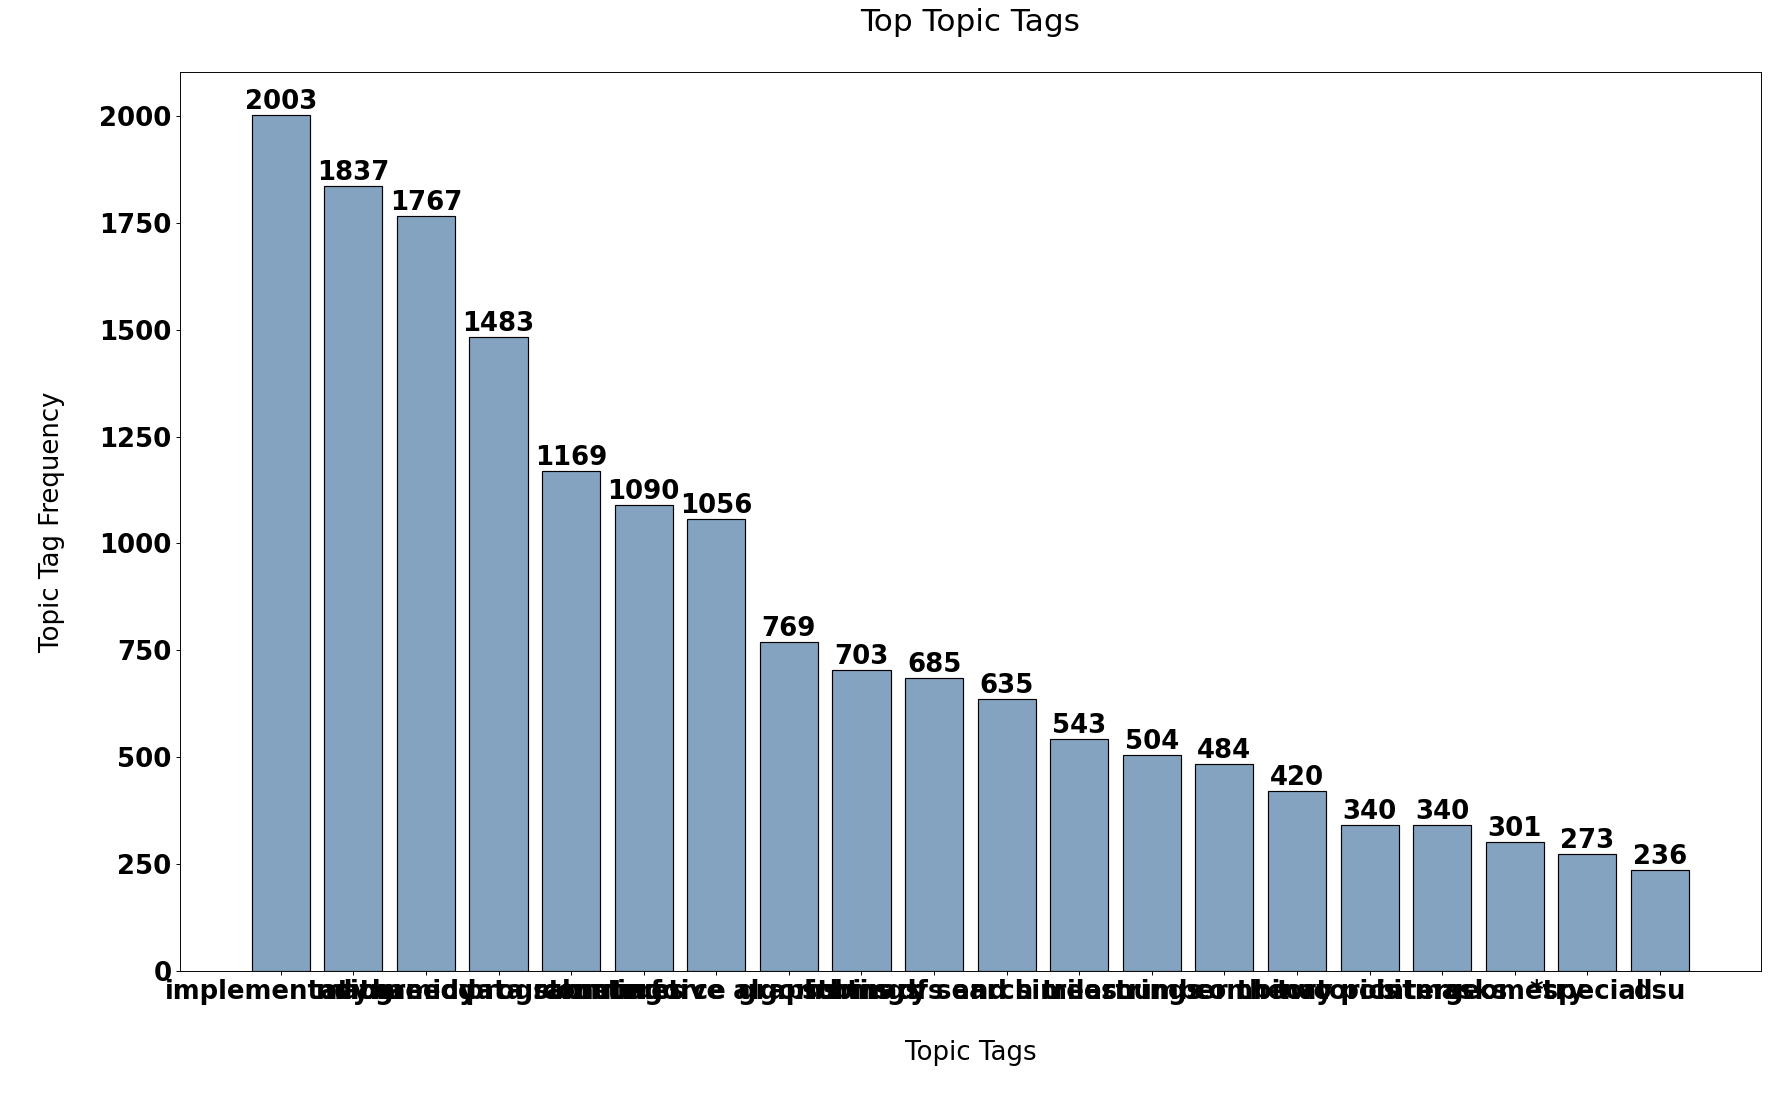

In [ ]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

top_10_topics = sorted(unique_topic_count, key=unique_topic_count.get, reverse=True)[:20]
print("Top 10 topic tags:\n", top_10_topics)

top_10_frequencies = [unique_topic_count[topic] for topic in top_10_topics]
fig1, ax1 = plt.subplots(figsize=(24,14), dpi=85)
bars1 = ax1.bar(top_10_topics, top_10_frequencies, edgecolor='black', color=(0.2, 0.4, 0.6, 0.6))
ax1.set_xlabel("\nTopic Tags\n")
ax1.set_ylabel("\nTopic Tag Frequency\n")
ax1.set_title("Top Topic Tags\n")
for bar in bars1: #labels
  x_pos = bar.get_x() + bar.get_width() / 2
  height = bar.get_height()
  ax1.text(x_pos, height + .25, s=round(height,3), ha='center', va='bottom')
plt.savefig("top10tags.png", bbox_inches="tight", transparent=True)
problem_categories = ['math', 'greedy', 'dynamic programming', 'graphs', 'trees', 'strings']


In [ ]:
# Before and after splitting 
# topic tags/duplicating samples
print(df_combined[['id',
                   'title',
                   'difficulty',
                   'description',
                   'topics',
                   'runtime']].iloc[0])

id                                    1
title                           Two Sum
difficulty                            1
description    Given an array of int...
topics                Array, Hash Table
runtime                               n
Name: 0, dtype: object


In [ ]:
print(final_topics_df_combined[['id','title','difficulty','description','topics','runtime']].iloc[0], "\n\n", final_topics_df_combined[['id','title','difficulty','description','topics','runtime']].iloc[1])

id                                    1
title                           Two Sum
difficulty                            1
description    Given an array of int...
topics                            array
runtime                               n
Name: 0, dtype: object 

 id                                    1
title                           Two Sum
difficulty                            1
description    Given an array of int...
topics                       hash table
runtime                               n
Name: 1, dtype: object


#### Run Times

runtime                                          
n                                                    750
1                                                    144
nlog(n)                                               98
n^2                                                   79
nm                                                    60
log(n)                                                38
n^3                                                   23
n+m                                                   18
k                                                      6
2^n                                                    6
nlog(k)                                                5
h                                                      5
nk                                                     4
n^4                                                    4
n!                                                     3
n^2k                                                   3
nmlog(nm)                             

(1169, 7)

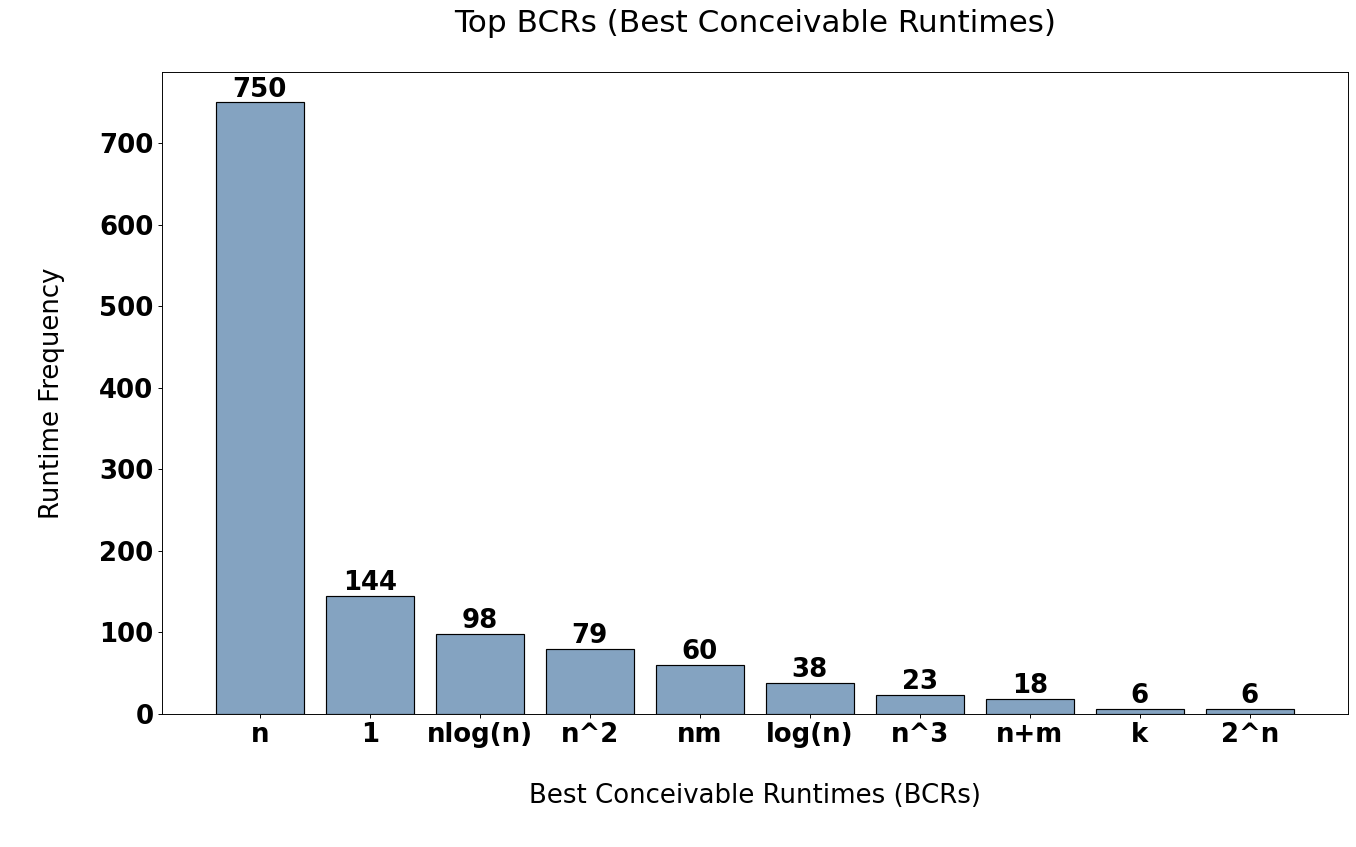

In [ ]:
# Create map of unique runtimes and their frequencies
unique_runtimes = df_combined.value_counts(subset=['runtime'])
print(unique_runtimes, "\n\n")
top_10_runtimes = [runtime[0] for runtime in unique_runtimes.index[:10]]
print("Top 10 runtimes:\n", top_10_runtimes, "\n\n")

top_10_frequencies = list(unique_runtimes[:10])
fig1, ax1 = plt.subplots(figsize=(18,10), dpi=85)
bars1 = ax1.bar(top_10_runtimes, top_10_frequencies, edgecolor='black', color=(0.2, 0.4, 0.6, 0.6))
ax1.set_xlabel("\nBest Conceivable Runtimes (BCRs)\n")
ax1.set_ylabel("\nRuntime Frequency\n")
ax1.set_title("Top BCRs (Best Conceivable Runtimes)\n")
for bar in bars1: #labels
  x_pos = bar.get_x() + bar.get_width() / 2
  height = bar.get_height()
  ax1.text(x_pos, height + .25, s=round(height,3), ha='center', va='bottom')
plt.savefig("top10runtimes.png", bbox_inches="tight", transparent=True)

top_6_runtimes = top_10_runtimes[:6]
df_lc_top6 = df_lc[df_lc['runtime'].isin(top_6_runtimes)]
df_lc_top6.shape


### Embeddings

#### Word2Vec

In [ ]:
#https://code.google.com/archive/p/word2vec/
'''import gensim.downloader as api

def download_word2vec_embeddings():
    print("Downloading pre-trained word embeddings from: word2vec-google-news-300.\n" 
          + "Note: This can take a few minutes.\n")
    wv = api.load("word2vec-google-news-300")
    print("\nLoading complete!\n")
    return wv

word_vector_model = download_word2vec_embeddings()'''

'import gensim.downloader as api\n\ndef download_word2vec_embeddings():\n    print("Downloading pre-trained word embeddings from: word2vec-google-news-300.\n" \n          + "Note: This can take a few minutes.\n")\n    wv = api.load("word2vec-google-news-300")\n    print("\nLoading complete!\n")\n    return wv\n\nword_vector_model = download_word2vec_embeddings()'

In [ ]:
'''from gensim.parsing.preprocessing import remove_stopwords, preprocess_string

def filter_words_not_in_model(sequence):
    for i in range(len(sequence)):
      if sequence[i] not in word_vector_model:
        sequence.pop(i)
        i -= 1
    return sequence

df_copy = df_combined.copy()
df_copy['description'] = df_copy['description'].apply(lambda x: x.split())
df_copy['description'] = df_copy['description'].map(lambda x: list(filter(lambda w: w in word_vector_model, x)))
df_copy['description'] = df_copy['description'].map(lambda x: [word_vector_model[w] for w in x])
df_copy.drop(['title_slug'], axis=1, inplace=True)
print(df_copy.shape)
df_copy = df_copy[df_copy['runtime'].isin(top_10_runtimes)]
print(df_copy.shape)'''

"from gensim.parsing.preprocessing import remove_stopwords, preprocess_string\n\ndef filter_words_not_in_model(sequence):\n    for i in range(len(sequence)):\n      if sequence[i] not in word_vector_model:\n        sequence.pop(i)\n        i -= 1\n    return sequence\n\ndf_copy = df_combined.copy()\ndf_copy['description'] = df_copy['description'].apply(lambda x: x.split())\ndf_copy['description'] = df_copy['description'].map(lambda x: list(filter(lambda w: w in word_vector_model, x)))\ndf_copy['description'] = df_copy['description'].map(lambda x: [word_vector_model[w] for w in x])\ndf_copy.drop(['title_slug'], axis=1, inplace=True)\nprint(df_copy.shape)\ndf_copy = df_copy[df_copy['runtime'].isin(top_10_runtimes)]\nprint(df_copy.shape)"

In [ ]:
#df_copy.iloc[0]

### Upsampling

We will be upsampling using SMOTE, which uses K-Means clustering to generate synthetic datapoints for the minority classes.

In [ ]:
'''# SMOTE oversampling on training data
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
df_copy['runtime'].fillna('', inplace=True)
#df_copy['title'] = vectorizer.fit_transform(df_copy['title'])
x_train = vectorizer.fit_transform(df_combined[df_combined['runtime'].isin(top_10_runtimes)]['description'])

sm = SMOTE(sampling_strategy='not majority', k_neighbors=3, random_state=0) # test k_neighbors=1-5
print(x_train.shape)
smote_upsampled_df, smote_labels = sm.fit_resample(x_train, df_copy['runtime'])
print(smote_upsampled_df.shape)
print(smote_labels.value_counts())'''

"# SMOTE oversampling on training data\nfrom imblearn.over_sampling import SMOTE\nfrom sklearn.feature_extraction.text import CountVectorizer\n\nvectorizer = CountVectorizer()\ndf_copy['runtime'].fillna('', inplace=True)\n#df_copy['title'] = vectorizer.fit_transform(df_copy['title'])\nx_train = vectorizer.fit_transform(df_combined[df_combined['runtime'].isin(top_10_runtimes)]['description'])\n\nsm = SMOTE(sampling_strategy='not majority', k_neighbors=3, random_state=0) # test k_neighbors=1-5\nprint(x_train.shape)\nsmote_upsampled_df, smote_labels = sm.fit_resample(x_train, df_copy['runtime'])\nprint(smote_upsampled_df.shape)\nprint(smote_labels.value_counts())"

#### BERT

In [ ]:
# used this guide: https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/
'''
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

"""
Converts a string sentence to tensor of BERT embeddings
Meant to be used with df.apply() where you feed in df['description'] as the input
"""
def convert_text_to_embeddings(sequence):
  # tokenize sentence and get hidden states
  inputs = tokenizer(sequence, return_tensors="pt")
  outputs = model(**inputs, output_hidden_states=True)

  # reshape and permute hidden states
  token_embeddings = torch.stack(list(outputs[2]), dim=0)
  token_embeddings = torch.squeeze(token_embeddings, dim=1)
  token_embeddings = token_embeddings.permute(1,0,2)

  # concatenate the last 4 hidden states to create token embeddings
  last_4_cat_embeddings = []
  for token in token_embeddings:
    final_embedding = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    last_4_cat_embeddings.append(final_embedding.view(1, -1))

  last_4_cat_embeddings = torch.stack(last_4_cat_embeddings, dim=0)
  return last_4_cat_embeddings
  '''

'\nfrom transformers import BertTokenizer, BertModel\n\ntokenizer = BertTokenizer.from_pretrained(\'bert-base-uncased\')\nmodel = BertModel.from_pretrained(\'bert-base-uncased\', output_hidden_states=True)\n\n"""\nConverts a string sentence to tensor of BERT embeddings\nMeant to be used with df.apply() where you feed in df[\'description\'] as the input\n"""\ndef convert_text_to_embeddings(sequence):\n  # tokenize sentence and get hidden states\n  inputs = tokenizer(sequence, return_tensors="pt")\n  outputs = model(**inputs, output_hidden_states=True)\n\n  # reshape and permute hidden states\n  token_embeddings = torch.stack(list(outputs[2]), dim=0)\n  token_embeddings = torch.squeeze(token_embeddings, dim=1)\n  token_embeddings = token_embeddings.permute(1,0,2)\n\n  # concatenate the last 4 hidden states to create token embeddings\n  last_4_cat_embeddings = []\n  for token in token_embeddings:\n    final_embedding = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)\n    la

In [ ]:
from transformers import BertTokenizer, BertModel, BertConfig
from imblearn.over_sampling import SMOTE

def generate_BERT_embeddings(df: 'DataFrame', tokenizer_name='bert-base-uncased', model_name='bert-base-uncased', upsampling=False):
  tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
  configuration = BertConfig(max_position_embeddings=256, output_hidden_states=True)
  model = BertModel.from_pretrained(model_name, output_hidden_states=True)

  device = torch.device('cpu')
  model.to(device)
  text = df.description.values

  attention_masks = []

  tokens = []

  print("Tokenizing:")
  for p in tqdm(text): 
    #tokens_dict = tokenizer.encode_plus(p, add_special_tokens=True, truncation=True, return_attention_mask=True, return_tensors='pt', padding='max_length')

    # encode_plus is deprecated, use __call__
    # https://huggingface.co/transformers/internal/tokenization_utils.html#transformers.tokenization_utils_base.PreTrainedTokenizerBase.encode_plus 
    tokens_dict = tokenizer(p, add_special_tokens=True, truncation=True, return_attention_mask=True, return_tensors='pt', padding='max_length') 
    tokens.append(tokens_dict['input_ids'])
    attention_masks.append(tokens_dict['attention_mask'])
  print(tokens_dict)
  tokens = torch.cat(tokens, dim=0).to(device) #Reformatting for correct shape
  print(tokens.shape)
  attention_masks = torch.cat(attention_masks, dim=0).to(device)
  if tokens.shape[0] != attention_masks.shape[0]:
    print("Something went wrong")
  
  if upsampling:
    sm = SMOTE(sampling_strategy='not majority', k_neighbors=3, random_state=0) # test k_neighbors=1-5
    df['runtime'].fillna('', inplace=True)
    tokens = tokens.to(torch.device('cpu'))
    tokens, smote_labels = sm.fit_resample(tokens, df['runtime'])
    #hidden_states = hidden_states.to(torch.device('cpu'))
    #hidden_states, smote_labels = sm.fit_resample(hidden_states.reshape(hidden_states.shape[0], hidden_states.shape[1]*hidden_states.shape[2]), df['runtime'])
    #print(hidden_states.shape)
    print(np.shape(tokens))
    indices = torch.randperm(len(tokens))[:int(.8*len(tokens))]
    smote_labels = smote_labels.iloc[indices]
    attention_masks = attention_masks[indices]
    tokens = torch.tensor(tokens).to(device) #Reformatting for correct shape
    tokens = tokens[indices]
    print(tokens.shape)

  model.eval()

  with torch.no_grad():
    hidden_states = torch.tensor([]).to(device)
    print("Embedding:")
    for i in tqdm(range(int(len(tokens) / 8) + 1)):
      start = 8*i
      end = min(8*(i+1), len(tokens))
      output = model(tokens[start:end])
      if not len(hidden_states):
        hidden_states = output[2][-1]
      else:
        hidden_states = torch.cat((hidden_states, output[2][-1]))
      
  if upsampling:
    return hidden_states, attention_masks, smote_labels
  else:
    return hidden_states, attention_masks

#### RoBERTa

In [ ]:
# from transformers import RobertaTokenizer, RobertaModel

# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# model = RobertaModel.from_pretrained('roberta-base')

# use convert_text_to_embeddings method from above

In [ ]:
# from transformers import RobertaTokenizer, RobertaModel

# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# model = RobertaModel.from_pretrained('roberta-base', output_hidden_states=True)
# tokens = []

# for p in text: 
#   tokens_dict = tokenizer.encode_plus(p, add_special_tokens=True, return_attention_mask=True, return_tensors='pt', padding='max_length')
#   tokens.append(tokens_dict['input_ids'])

# tokens = torch.cat(tokens, dim=0) #Reformatting for correct shape

# model.eval()

# with torch.no_grad():
#   output = model(tokens)
#   hidden_states = output[2]

# Roberta_embeddings = hidden_states[-1]
# print(Roberta_embeddings.shape)
# # print(BERT_embeddings[0][0])

#### FastText for Domain-Specific Embeddings

##Clustering

###KNN on Runtime

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,3), max_features=512)
X = tfidf_vectorizer.fit_transform(df_lc_top6['description']).toarray()

In [ ]:
difficulty_labels = df_lc_top6.difficulty.values - 1
runtime_labels = df_lc_top6.runtime.values
topic_labels = df_lc_top6.topics.values
print(X.shape, difficulty_labels.shape, runtime_labels.shape, topic_labels)

(1169, 512) (1169,) (1169,) [' Array, Hash Table' ' Hash Table, String, Sliding Window'
 ' String, Dynamic Programming' ... nan nan nan]


In [ ]:
def KNN(embedding, labels, test, k: int):
  embedding = embedding.reshape(embedding.shape[0], -1)
  test = test.reshape(-1)
  print(embedding.shape, test.shape)
  dist = embedding - test
  dist = torch.from_numpy(dist)
  dist = torch.norm(dist, dim=1)
  knn = dist.topk(k, largest=False)
  
  print('kNN dist: {}, index: {}'.format(knn.values, knn.indices))
  
  counts = {}
  
  for index in knn.indices:
    label = labels[index]
    if label not in counts: counts[label] = 0
    counts[label] += 1
  # print(counts)
  label = max(counts, key=counts.get)
  return label

KNN(X, difficulty_labels, X[0], 50)




(1169, 512) (512,)
kNN dist: tensor([0.0000, 0.8900, 0.9648, 0.9802, 0.9809, 0.9964, 1.0348, 1.0381, 1.0499,
        1.0512, 1.0663, 1.0727, 1.0763, 1.0777, 1.0831, 1.0832, 1.0835, 1.0876,
        1.0995, 1.0999, 1.1040, 1.1040, 1.1127, 1.1143, 1.1144, 1.1159, 1.1179,
        1.1245, 1.1351, 1.1355, 1.1364, 1.1376, 1.1386, 1.1419, 1.1422, 1.1430,
        1.1436, 1.1439, 1.1442, 1.1445, 1.1455, 1.1510, 1.1511, 1.1535, 1.1538,
        1.1581, 1.1583, 1.1586, 1.1607, 1.1613], dtype=torch.float64), index: tensor([   0,   23,  431,   11,  857,  141,   95,  236, 1146,  826,  322,  155,
        1061,  730,  827,   24,  540,  147,  389,  533,  207,  283,  750,  277,
         841,  877,  308,  192,  294,  164,  170,  199,  145,  103,  272,  269,
        1137,   61,  273,   22,  801, 1030,  923,  783,  416,  591,  784,  125,
         965,  866])


1

num_features=1: 0.05873494358043978
num_features=2: 0.09729221908236543
num_features=3: 0.1277628949227046
num_features=4: 0.15031610386094324
num_features=5: 0.16588859956325175
num_features=6: 0.18029552684458056
num_features=7: 0.19316080665319685
num_features=8: 0.20484006326469925
num_features=9: 0.2156638283925432
num_features=10: 0.22622078714128216
num_features=11: 0.23664170762359488
num_features=12: 0.24667025078873403
num_features=13: 0.2561311933834814
num_features=14: 0.2652108304691389
num_features=15: 0.27408747228094316
num_features=16: 0.2828076959327868
num_features=17: 0.291225947675917
num_features=18: 0.29925608688938926
num_features=19: 0.3070901510903426
num_features=20: 0.31471493945295564
num_features=21: 0.3221869242322615
num_features=22: 0.3294067592735509
num_features=23: 0.336371627389578
num_features=24: 0.3432140643667498
num_features=25: 0.34977493039642577
num_features=26: 0.35625866786746174
num_features=27: 0.3629873675330112
num_features=28: 0.36926

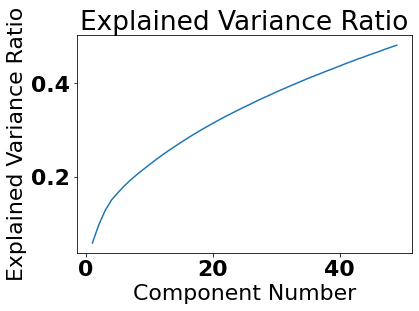

In [ ]:

def PCA_graph(embedding, max_components):
  embedding = embedding.reshape(embedding.shape[0], -1)
  variance_vals = []
  for i in range(1, max_components):
    pca = decomposition.PCA(n_components=i)
    pca.fit(embedding)
    variance_vals.append(sum(pca.explained_variance_ratio_))
    print("num_features={}: {}".format(i, variance_vals[-1]))

  plt.plot(range(1, max_components), variance_vals)
  plt.title('Explained Variance Ratio')
  plt.xlabel('Component Number')
  plt.ylabel('Explained Variance Ratio')
  plt.show()

PCA_graph(X, 50)

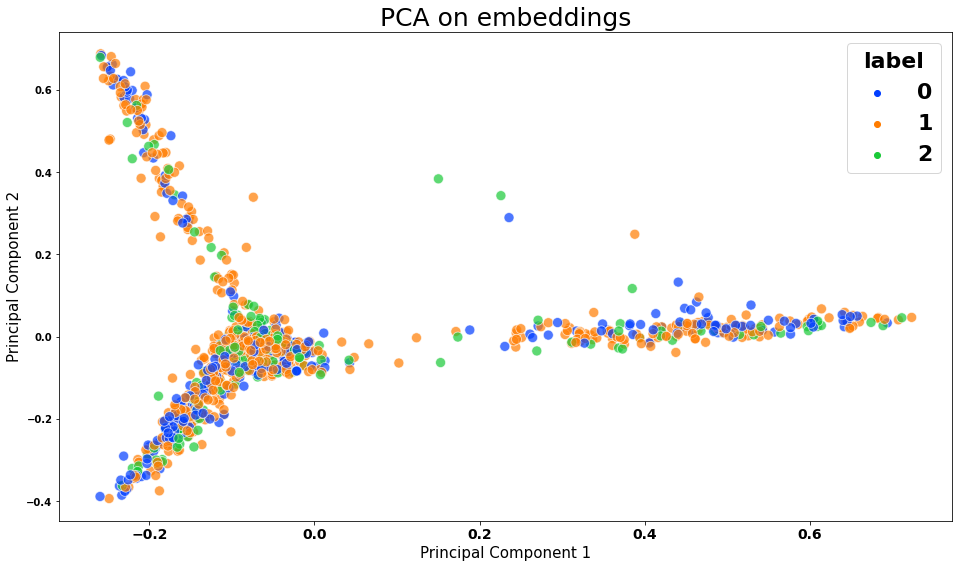

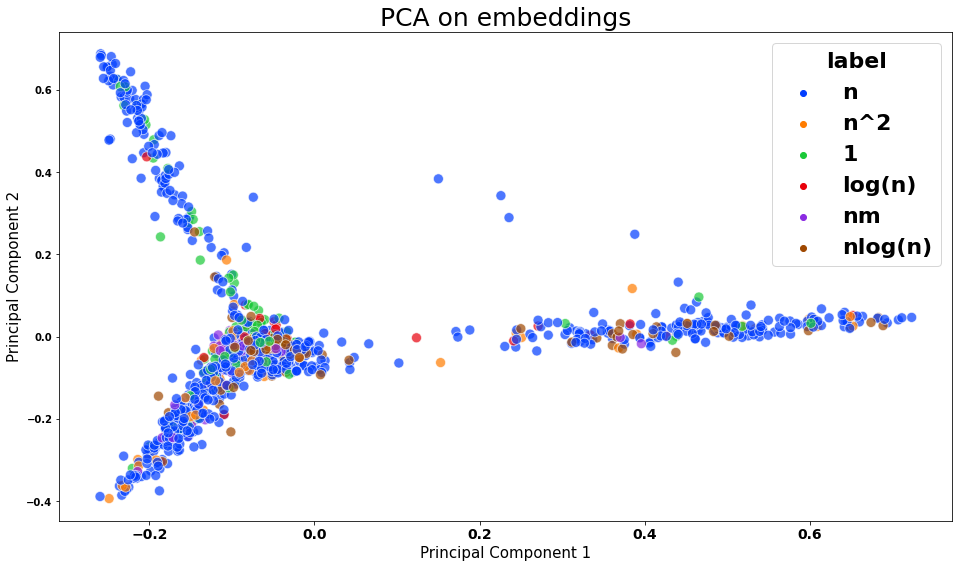

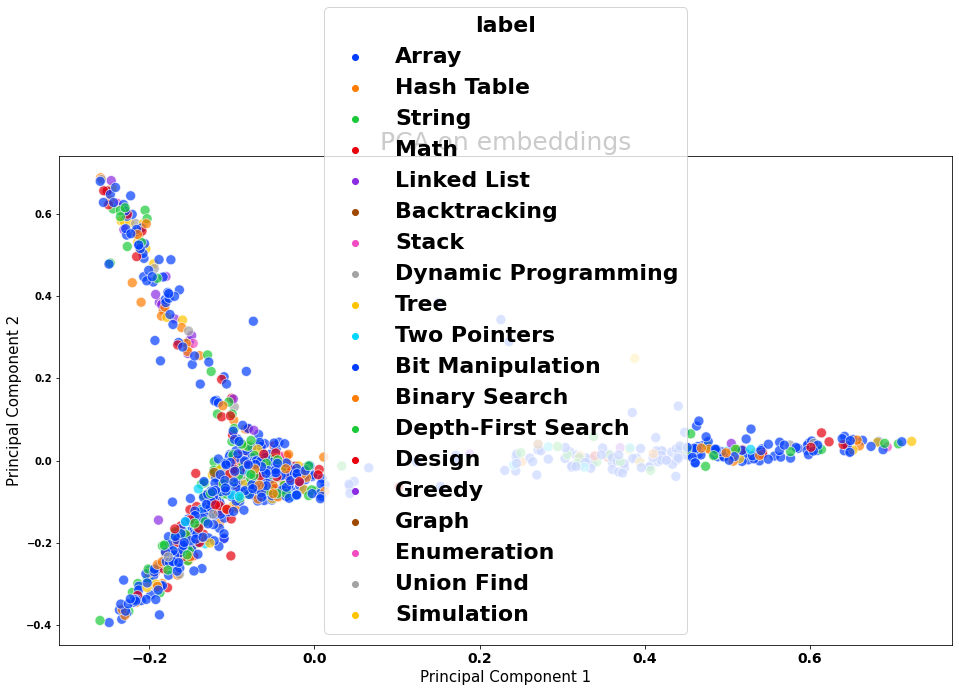

In [ ]:

def PCA_graph(embedding, labels, components, isTopicLabel=False):
  embedding = embedding.reshape(embedding.shape[0], -1)
  features_transformed = decomposition.PCA(n_components=components).fit_transform(embedding)
  pca_df = pd.DataFrame(features_transformed)
  # print(labels)
  labels = pd.DataFrame({"label": labels})
  labels.dropna(subset = ["label"], inplace=True)
  if isTopicLabel:
    labels = np.array([label.split(', ')[0].strip() for label in labels['label']])
    labels = pd.DataFrame({"label": labels})
  finalDf = pd.concat([pca_df, labels], axis = 1)
  # print(finalDf)
  plt.figure(figsize = (16, 9))
  sns.scatterplot(x=0, y=1, data=finalDf, palette="bright", hue="label", alpha=0.7, s=100)
  plt.title('PCA on embeddings', fontsize = 25)
  plt.xticks(fontsize = 14)
  plt.yticks(fontsize = 10);
  plt.xlabel("Principal Component 1", fontsize = 15)
  plt.ylabel("Principal Component 2", fontsize = 15)

PCA_graph(X, difficulty_labels, 2)
PCA_graph(X, runtime_labels, 2)
PCA_graph(X, topic_labels, 2, True)

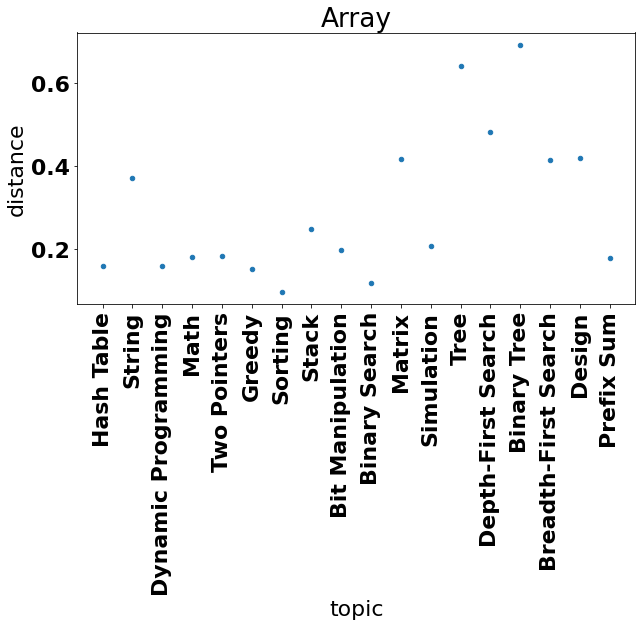

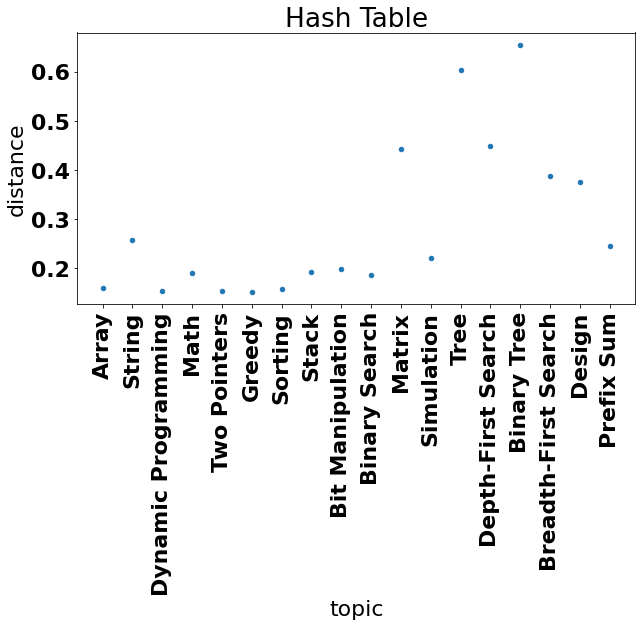

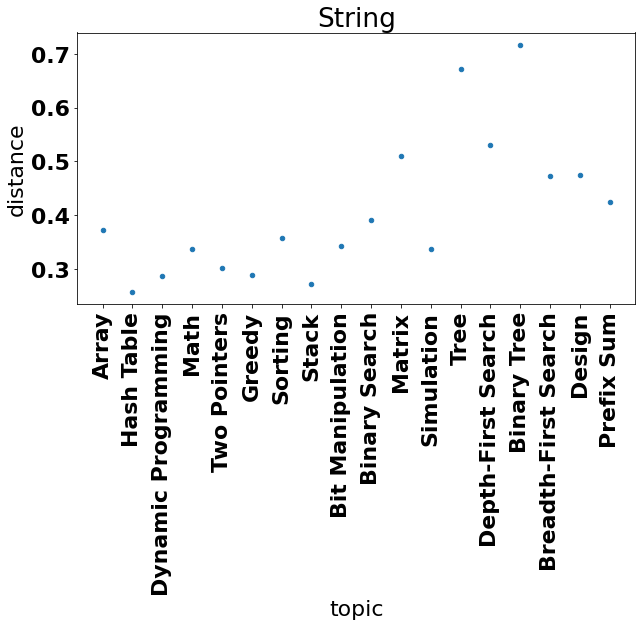

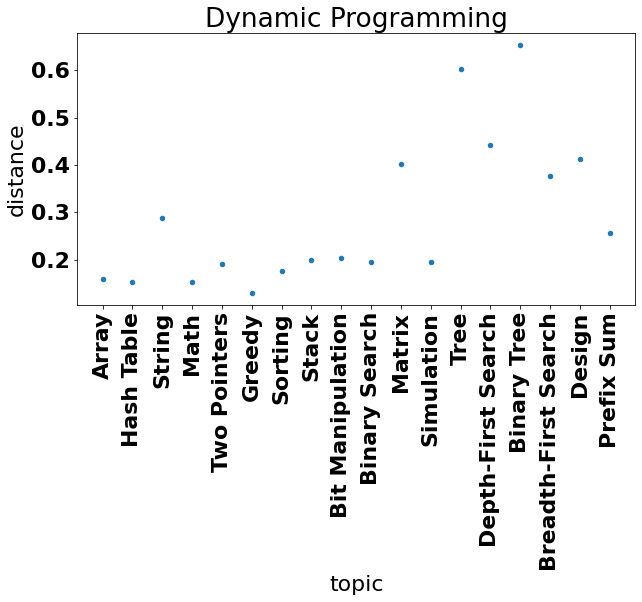

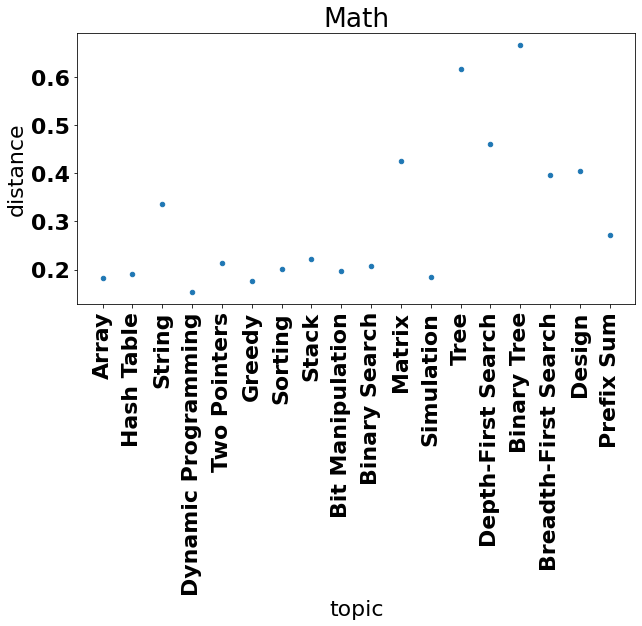

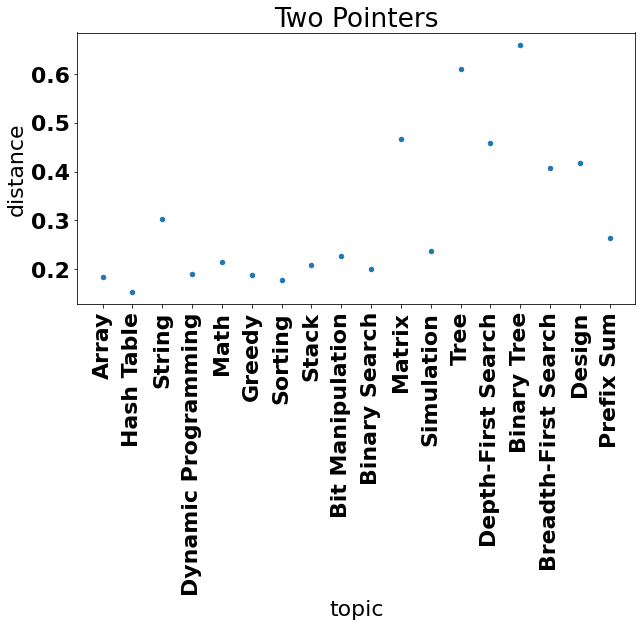

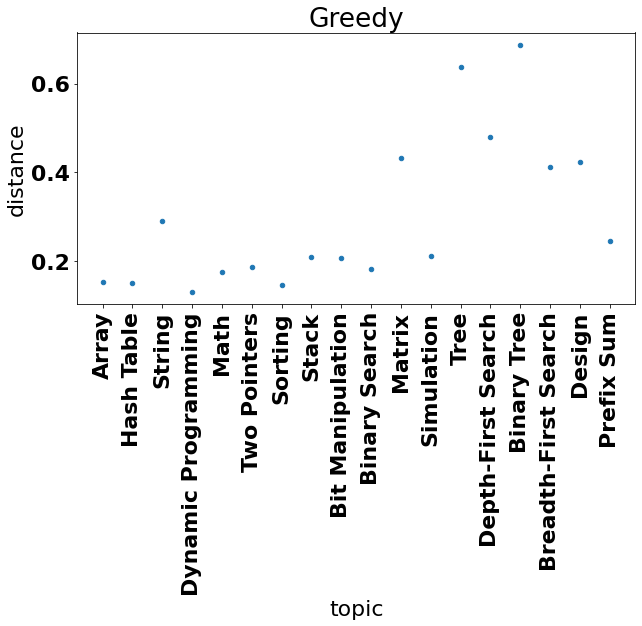

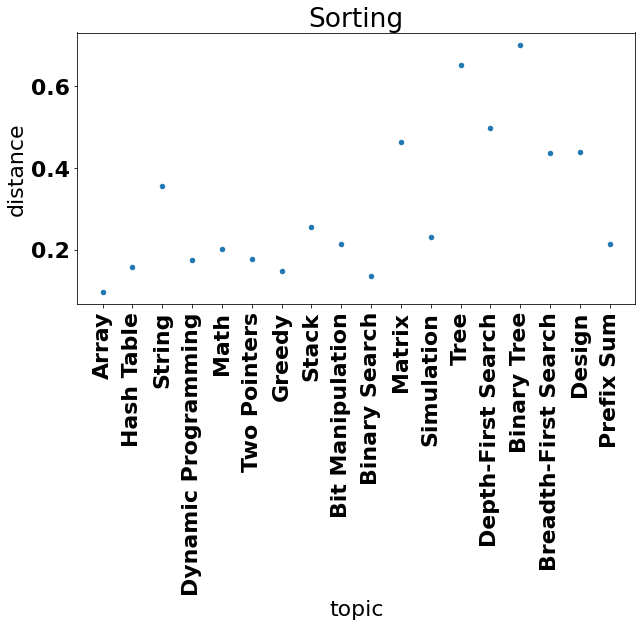

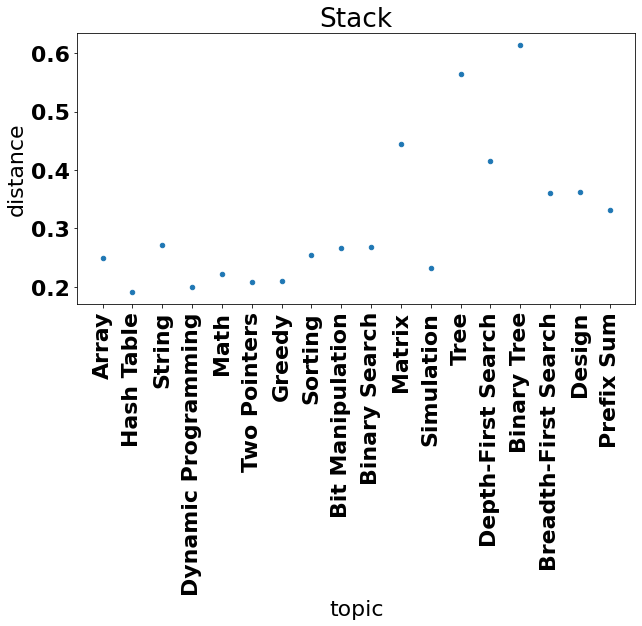

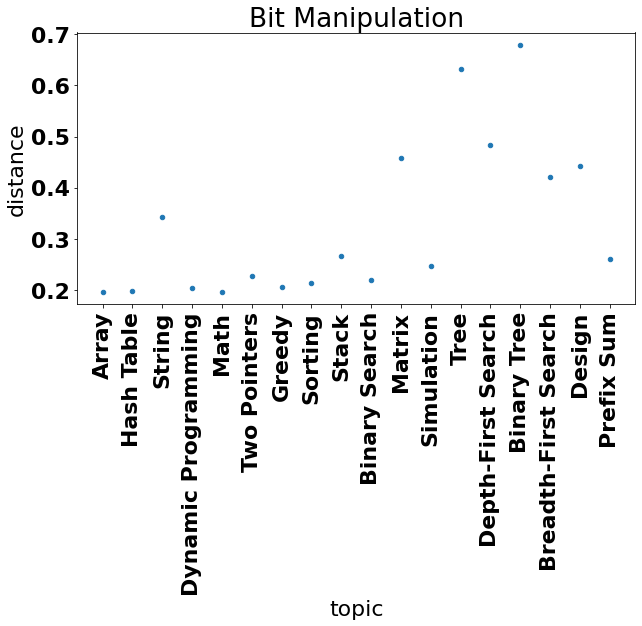

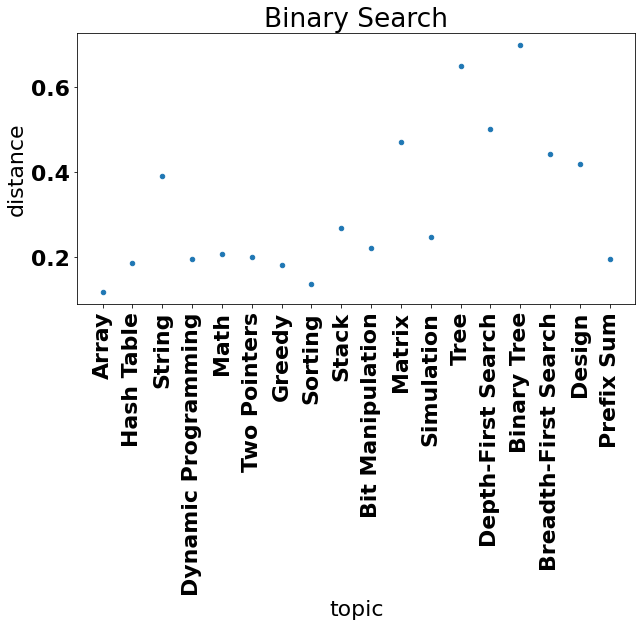

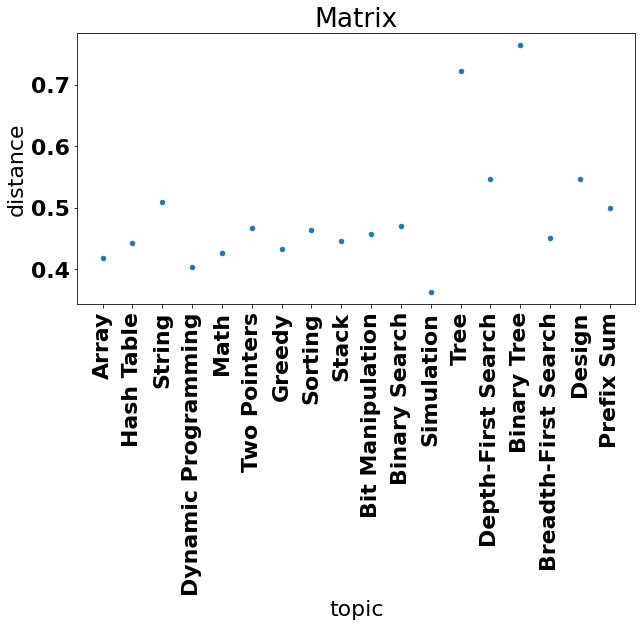

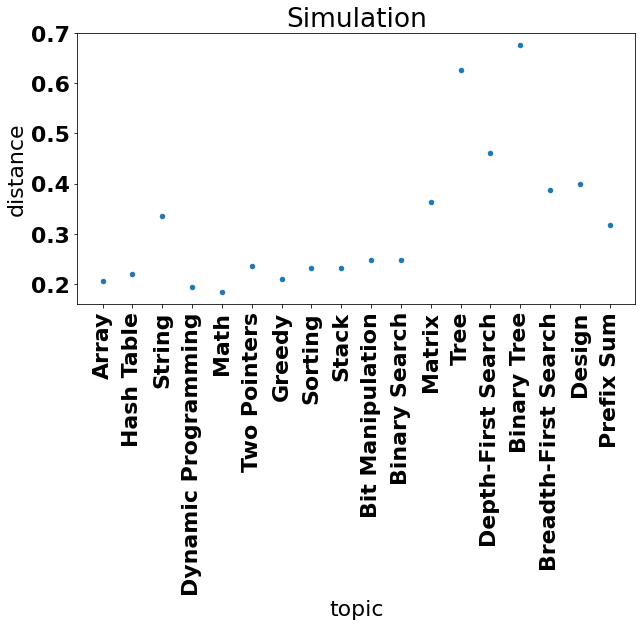

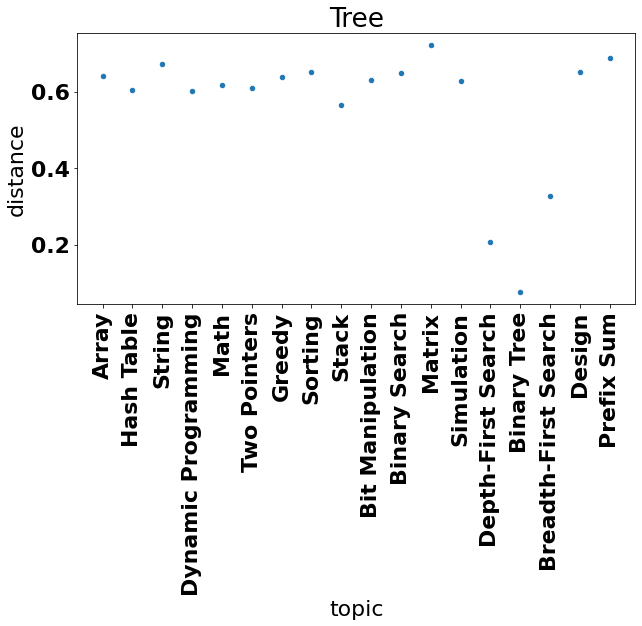

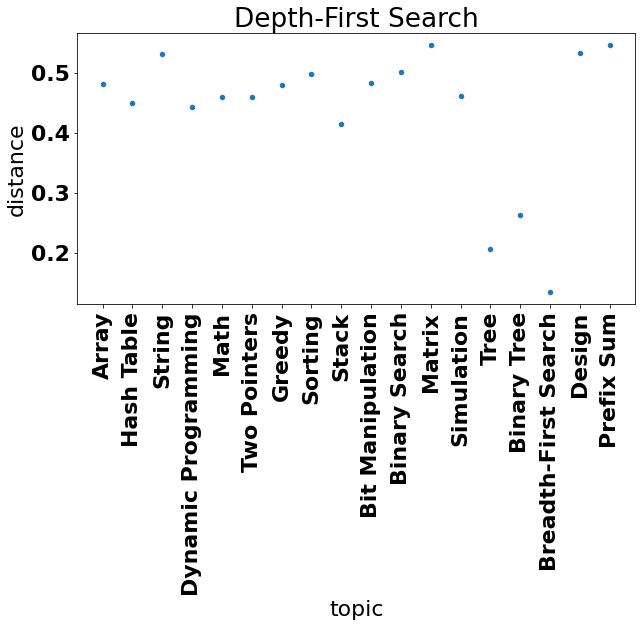

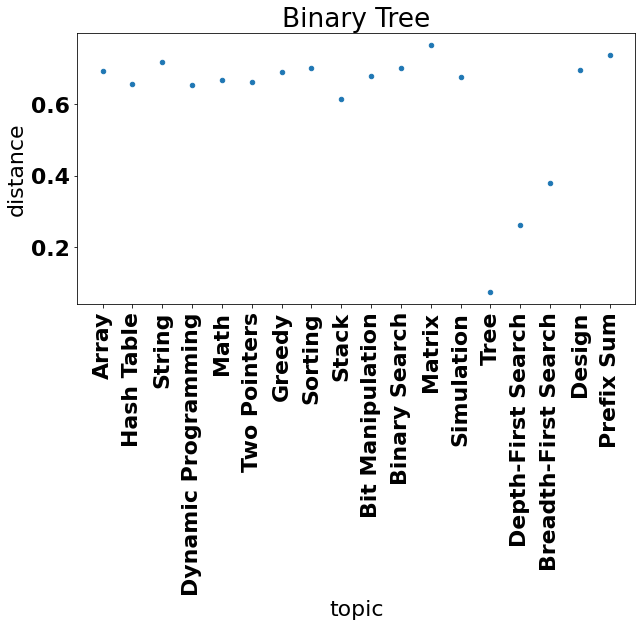

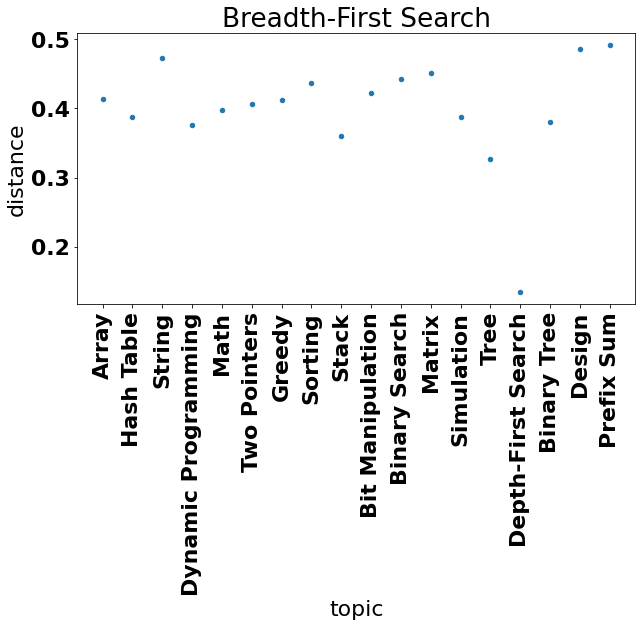

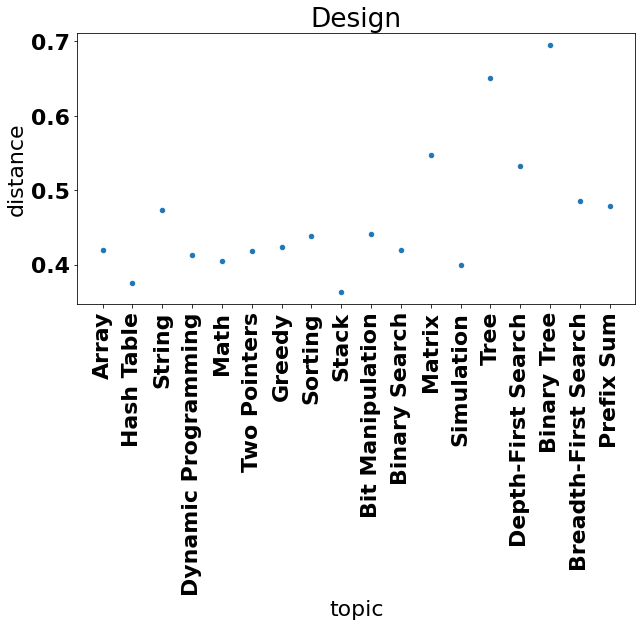

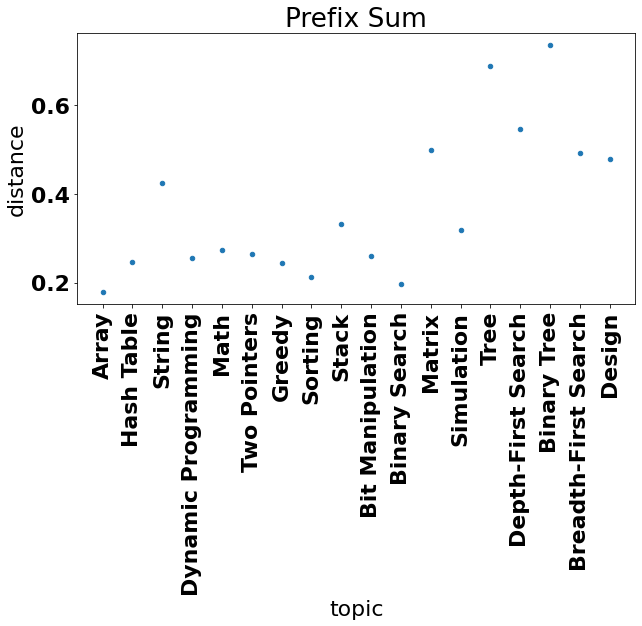

In [ ]:

def plotTopicSimilarity(embedding, labels, components):
  embedding = embedding.reshape(embedding.shape[0], -1)
  num_problems, num_features = embedding.shape
  # features_transformed = decomposition.PCA(n_components=components).fit_transform(embedding)
  # pca_df = pd.DataFrame(features_transformed)
  # print(labels)
  # labels = pd.DataFrame({"label": labels})
  # labels.dropna(subset = ["label"], inplace=True)
  embedding_average = {}
  topic_freq = {}

  for problem_idx in range(num_problems):
    problem_topics = labels[problem_idx]
    if str(problem_topics) == 'nan': continue
    for problem_topic in problem_topics.split(', '):
      problem_topic = problem_topic.strip()
      if problem_topic not in topic_freq:
        topic_freq[problem_topic] = 0
        embedding_average[problem_topic] = [0] * num_features
      topic_freq[problem_topic] += 1
      embedding_average[problem_topic] += embedding[problem_idx]

  for topic, freq in topic_freq.items():
    if freq <= 50: # remove infrequent topics
      # topic_freq.pop(topic, None)
      embedding_average.pop(topic)
      continue
    embedding_average[topic] /= freq;
  # print(len(embedding_average.keys()))

  # figure out how similar topics are? compare topics
  for topic_i in embedding_average.keys():
    similarity_df = pd.DataFrame(columns=('distance', 'topic'))
    idx = 0
    for topic_j in embedding_average.keys():
      if topic_i == topic_j: continue
      distance = np.linalg.norm(embedding_average[topic_i] - embedding_average[topic_j])
      # print(topic_i, topic_j, distance)
      similarity_df.loc[idx] = [distance, f'{topic_j}']
      idx += 1      
    similarity_df.plot(x='topic', y='distance', kind='scatter', figsize=(10, 5), title=topic_i)
    plt.xticks(rotation=90)
  # finalDf = pd.concat([pca_df, labels], axis = 1)
  # # print(finalDf)
  # plt.figure(figsize = (16, 9))
  # sns.scatterplot(x="distance", data=similarity_df, palette="bright", hue="label", alpha=0.7, s=100)
  # plt.title('PCA on embeddings', fontsize = 25)
  # # plt.
  # plt.xticks(fontsize = 14)
  # plt.yticks(fontsize = 10);
  # plt.xlabel("Principal Component 1", fontsize = 15)
  # plt.ylabel("Principal Component 2", fontsize = 15)

plotTopicSimilarity(X, topic_labels, 2)

In [ ]:
def plotPCA(embedding, components):
  embedding = embedding.reshape(embedding.shape[0], -1)
  model = decomposition.PCA(n_components=components)
  model.fit(embedding)
  first_component = model.components_[0, :]
  plt.bar(embedding.columns, model.components_[0, :])
  plt.show()
  plt.bar(embedding.columns, model.components_[1, :])
  plt.show()

plotPCA(X, 5)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-111-ae929e4b65a8>", line 11, in <module>
    plotPCA(X, 5)
  File "<ipython-input-111-ae929e4b65a8>", line 6, in plotPCA
    plt.bar(embedding.columns, model.components_[0, :])
AttributeError: 'numpy.ndarray' object has no attribute 'columns'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    re

AttributeError: ignored

In [ ]:
# the ith -> embedding[i] is the problem description embedding for the ith problem, topics[i] are the topics for the ith problem
def plotTopicSimilarity(embedding, topics, topic_labels):
  embedding = embedding.reshape(embedding.shape[0], -1)
  num_problems, num_features = embedding.shape
  topicFreq = {}
  topicEmbedding = {}
  for index in range(num_problems):
    topics = topic_labels[index].split(', ')
    topic = topics[0].strip() # just grab first one for now
    if topic not in topicFreq:
      topicFreq[topic] = 0
      topicEmbedding[topic] = [0] * num_features
    topicFreq[topic] += 1
    topicEmbedding[topic] += embedding[index]

  for topic, freq in topicFreq.items():
    topicEmbedding[topic] /= freq;

  print(topicFreq)
  print(topicEmbedding)
  
  # for each topic, determine 1) count and 2) embedding total
  # 
plotTopicSimilarity(X, topic_labels, topic_labels)

## Classification Model Training

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_auc_score

### Utilities

#### Testing/Training Loops

In [ ]:
def loss(model, loss_fn, x, y, pre_trained, seq_len, device='cpu'):
    """
    Helper function to calculate loss for a set of samples
    :param model: model to use for the forward pass
    :param loss_fn: loss function to apply
    :param x: samples in
    :param y: labels out
    :param pre_trained: are we passing in embeddings or indices? Boolean: true for embeddings
    :param seq_len: sequence length
    :param device: device to put tensors on
    :return: torch loss value, accuracy number, and length of x (for reporting)
    """

    # If the length of x is not evenly divisible by your sequence length, need to fit the data somehow
    # Either remove trailing data, or (if x is too small), just set sequence-length to the length of x
    batch_size = BATCH_SIZE
    if pre_trained and len(x) % seq_len != 0:
        if len(x) < seq_len:
            seq_len = len(x)
        remainder = len(x) % seq_len
        if remainder % seq_len != 0:
          x = x[:-remainder]
          y = y[:-remainder]
    if not pre_trained and len(x) <  batch_size:
      batch_size = len(x)

    # If we have embeddings going in, reshape to the batch x sequence x embed size
    # Else, just flatten into batches x seq_len (and cast to long)
    # cast labels to long and put everything on the right device
    # Pass through model, get loss with loss_fun, get accuracy from predictions,
    ### YOUR CODE GOES HERE
    old_x = x
    # x, y = torch.Tensor(x).to(device), torch.Tensor(y).to(device)
    if pre_trained:
        x = x.view(-1, seq_len, model.embedding_dim)
    else:
        x = x.view(batch_size, seq_len)
    x = x.float() if pre_trained else x.long()
    pred = model(x)
    # flatten = len(pred)
    # pred = pred.view(seq_len * len(pred), -1).float()
    # y = y.view(seq_len * flatten).long()
    pred = pred.float().to(device)
    y = y.type(torch.LongTensor).to(device)
    #print(pred.shape, y.shape)
    loss_value = loss_fn(pred, y)
    pred = torch.argmax(pred, dim=1)
    accuracy_value = torch.sum(torch.eq(pred, y)).item()
    x = old_x
    ### YOUR CODE ENDS HERE
    return loss_value, accuracy_value, len(x), pred


def train_loop(model, optimizer, loss_fn, samples, labels,
               batch_size, seq_len, device='cpu', pre_trained=False):
    """
    Standard pytorch training loop, using our helper loss function above.
    :param model: model to optimize
    :param optimizer: optimizer
    :param loss_fn: loss function
    :param samples: data in
    :param labels: labels out
    :param batch_size: batch size for sequences
    :param seq_len: sequence length
    :param device: device to put tensors on
    :param pre_trained: are we using pre-made embeddings or passing in indices?
    :return: model, loss, and accuracy
    """
    loss_total = 0
    acc_total = 0
    total_samples = 0
    # iterate through all samples, stepping by batch_size * sequence length and using
    # your loss function above to calculate loss. Then, zero gradients, backprop, step optimizer, and repeat
    # Also, store up the loss total, total number correct, and total number processed by the model so far
    predictions = []
    for i in range(0, len(samples), batch_size):
        ### YOUR CODE GOES HERE (delete the continue)
        model.zero_grad()
        pred = samples[i:min(i+batch_size, len(samples))]
        batch_labels = labels[i:min(i+batch_size, len(samples))]
        loss_val, acc_val, len_x, predicted = loss(model, loss_fn, pred, batch_labels, pre_trained, seq_len, device=device)
        predictions = predictions + predicted.tolist()
        loss_total += loss_val.item()
        acc_total += acc_val
        total_samples += len_x
        loss_val.backward()
        optimizer.step()

        ### YOUR CODE ENDS HERE
    # Return model, loss, and accuracy
    return model, loss_total, acc_total/total_samples, predictions


def val_loop(model, loss_fn, samples, labels, batch_size, seq_len, device='cpu', pre_trained=False):
    """
    Standard pytorch validation loop, using our helper loss function above
    :param model: model to test
    :param loss_fn: loss function to evaluate with
    :param samples: data in
    :param labels: labels out
    :param batch_size: batch size
    :param seq_len: sequence length
    :param device: device to put tensors on
    :param pre_trained: are we using pre-trained embeddings or indices?
    :return: loss and accuracy for evaluation
    """
    loss_total = 0
    acc_total = 0
    total_samples = 0
    predictions = []
    with torch.no_grad():
        # Again, step through data taking batch_size*sequence_length sized steps
        # For each step, use your helper loss function to get a loss value and accuracy total
        # DO NOT STEP THE OPTIMIZER OR BACKPROP THE LOSS
        for i in range(0, len(samples), batch_size):
            ### YOUR CODE GOES HERE (delete the continue)
            pred = samples[i:min(i+batch_size, len(samples))]
            batch_labels = labels[i:min(i+batch_size, len(samples))]
            loss_val, acc_val, len_x, predicted = loss(model, loss_fn, pred, batch_labels, pre_trained, seq_len, device=device)
            predictions = predictions + predicted.tolist()
            loss_total += loss_val.item()
            acc_total += acc_val
            total_samples += len_x
            ### YOUR CODE ENDS HERE
    # Return loss and accuracy
    return loss_total, acc_total/total_samples, predictions

#### LSTM

In [ ]:
class LSTMModel(nn.Module):
  def __init__(self,
                 vocab_size,
                 embedding_dim,
                 use_embeds,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional):
    super().__init__()
    self.use_embeds = use_embeds
    self.bidirectional = bidirectional
    self.embedding_dim = embedding_dim
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, bidirectional=bidirectional, batch_first=True)
    self.linear = nn.Linear(hidden_dim, output_dim)
    self.linear_bidirectional = nn.Linear(hidden_dim*2, output_dim)
    
  def forward(self, data_in):
    if not self.use_embeds:
      data_in = self.embedding(data_in)
    else:
    #print('embedding', data_in.shape)
      data_in = data_in.reshape((data_in.shape[1],512,768))
    _, (data_in, _) = self.lstm(data_in)
    #print('lstmout', data_in.shape)
    if self.bidirectional:
        data_in = torch.cat((data_in[0], data_in[1]), dim=1)
        #print('lstmout', data_in.shape)
        data_in = self.linear_bidirectional(data_in)
    else:
        data_in = self.linear(data_in)
    #print('linout', data_in.shape)
    ### YOUR CODE ENDS HERE
    return data_in

### Category Model

In [ ]:
# Category Model
df_lc.keys()

Index(['id', 'title', 'title_slug', 'difficulty', 'description', 'topics',
       'runtime'],
      dtype='object')

### Difficulty Model

#### Logistic Regression

In [ ]:
# The idea here was to store our embeddings in .pt files to fix our memory issues, but the actual limitation was the sheer size of the tensors, so the memory issues persisted.
# Difficulty Model
#X, attention_masks, y = generate_BERT_embeddings(df_lc_top6[:int(len(df_lc_top6)/2)], upsampling=True)
#X_2, attention_masks_2, y_2 = generate_BERT_embeddings(df_lc_top6[-int(len(df_lc_top6)/2):], upsampling=True)

#torch.save(X_2, 'bert_embeddings_other_half.pt')
#torch.save(y_2, 'upsampled_labels_other_half.pt')
#torch.save(attention_masks_2, 'bert_attention_other_half.pt')
# raise Exception
# half = torch.load('bert_embeddings_half.pt')
# other_half = torch.load('bert_embeddings_other_half.pt')
# X = torch.cat((half, other_half), dim=0)
# print(X.shape)

# attention_half = torch.load('bert_attention_half.pt')
# attention_other_half = torch.load('bert_attention_other_half.pt')
# attention_masks = torch.cat((attention_half, attention_other_half), dim=0)

# labels_half = torch.load('upsampled_labels_half.pt')
# labels_other_half = torch.load('upsampled_labels_other_half.pt')
# y = pd.concat([labels_half, labels_other_half], axis=0)
# print(labels_half.shape, labels_other_half.shape, y.shape)

In [ ]:
### For Runtimes
#X, attention_masks = generate_BERT_embeddings(df_lc_top6)
#y = df_lc_top6['runtime'].values

### For Difficulties
# X, attention_masks = generate_BERT_embeddings(df_lc)
# y = df_lc['difficulty'].values - 1

### For Topics
topics_subset = final_topics_df_combined[final_topics_df_combined['topics'].str.lower().isin(problem_categories)]
topics_subset = topics_subset.sample(frac=.25) 
X, attention_masks = generate_BERT_embeddings(topics_subset)
y = topics_subset['topics'].values

In [ ]:
X = X.to(torch.device('cpu'))
attention_masks = torch.unsqueeze(attention_masks, 2)
attention_masks = attention_masks.to(torch.device('cpu'))
print(X.shape)
print(attention_masks.shape)
# print(attention_masks[0])

In [ ]:
# X = torch.mean(X, dim=1)
attention_masks = torch.tensor(attention_masks)
X_attention = X*attention_masks
print(f"1: {X_attention.shape}")
X_attention = torch.sum(X_attention,axis=1)
print(f"2: {X_attention.shape}")
attention_sums = torch.sum(attention_masks, axis=1)
print(f"3: {attention_sums.shape}")
X_in = X_attention/attention_sums
# X_in = torch.tensor([])
# for i in range(len(X_attention)):
#   X_in.append(torch.sum(X_attention[i])/torch.sum(tokens_dict['attention_masks'][i]))

X_in.shape

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
### For TF-IDF Baseline:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,3), max_features=2400)
  ## for runtimes:
# X_in = tfidf_vectorizer.fit_transform(df_lc_top6['description']).toarray()
# y = df_lc_top6['runtime'].values

  ## for difficulties:
# X_in = tfidf_vectorizer.fit_transform(final_difficulty_df_combined['description']).toarray()
# y = final_difficulty_df_combined['difficulty'].values - 1

  ## for topics:
topics_subset = final_topics_df_combined[final_topics_df_combined['topics'].str.lower().isin(problem_categories)]
X_in = tfidf_vectorizer.fit_transform(topics_subset['description']).toarray()
y = topics_subset['topics'].values

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_auc_score

#trying Raj's BERT
#X_in = df['description'].apply(lambda x: convert_text_to_embeddings(x))

# nsamples, nx, ny = X.shape
# X2 = X.reshape((nsamples,nx*ny))
# x_train = X[:int(X.shape[0]*.8)]
# y_train = y.iloc[:int(X.shape[0]*.8)]
# x_test = X[int(X.shape[0]*.8):]
# y_test = y.iloc[int(X.shape[0]*.8):]
x_train, x_test, y_train, y_test = train_test_split(X_in, y, test_size=0.2)
print(f"XTrain: {x_train.shape}, XTest: {x_test.shape}")
print(f"YTrain: {y_train.shape}, YTest: {y_test.shape}")
# x_train, y_train = x_train.to(torch.device('cpu')), y_train.to(torch.device('cpu'))

fine_grid = [0.05, 0.01, 0.005, 0.001]
grid = [10, 1, 0.1, 0.01, 0.001]
for i in grid:
  lr = LogisticRegression(C=i,class_weight='balanced', max_iter=1600, penalty='l2')
  lr.fit(x_train, y_train)
  print(i, '\n')
  print(lr.predict(x_train[0:20]), '\n')
  print('training accuracy', lr.score(x_train, y_train), '\n')
  print('testing accuracy', lr.score(x_test, y_test), '\n')
  print('weighted f1', f1_score(y_test, lr.predict(x_test), average='weighted'))
  print(roc_auc_score(y_test, lr.predict_proba(x_test), multi_class='ovo'), "\n\n")

#### LSTM

In [ ]:
#Hyperparams
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(DEVICE)
BATCH_SIZE = 8
SEQ_LEN = 512
NUM_EPOCHS = 20
PRE_TRAINED = False
BIDIRECTIONAL = True
SHUFFLE=False
hidden_dim = 256
num_layers = 2
embed_dim = 768
bow = set()
output_size=6

for i in range(len(df_lc)):
  for word in df_lc.iloc[i]['description'].split(' '):
    bow.add(word)
vocab_size = len(bow)


cuda:0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

### for runtimes (tfidf/our own embeddings)
# tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,3), max_features=512)
# X = tfidf_vectorizer.fit_transform(df_lc_top6['description']).toarray()
# y = df_lc_top6['runtime'].apply(lambda x: ['n', '1', 'nlog(n)', 'n^2', 'nm', 'log(n)'].index(x)).values #for runtimes
###

### for runtimes (BERT embeddings)
#X, attention_masks = generate_BERT_embeddings(df_lc_top6)
#y = df_lc_top6['runtime'].apply(lambda x: ['n', '1', 'nlog(n)', 'n^2', 'nm', 'log(n)'].index(x)).values #for runtimes
###


### for topics/categories classification (BERT embeddings)

#topics_subset = final_topics_df_combined.sample(frac=.15) 

# topics_subset = topics_subset[topics_subset['topics'].str.lower().isin(top_10_topics)]

# topics_dict = {}
# count = 0
# for x in topics_subset['topics']:
#   if x not in topics_dict:
#     topics_dict[x] = count
#     count += 1
# print(len(topics_subset))

# output_size = count

# y = topics_subset['topics'].apply(lambda x: topics_dict[x]).values

# X, attention_masks = generate_BERT_embeddings(topics_subset)
###

### for topics/categories classification (our own embeddings)
# print(len(final_topics_df_combined))
# topics_subset = final_topics_df_combined[final_topics_df_combined['topics'].str.lower().isin(problem_categories)]
# print(len(topics_subset))

# topics_dict = {}
# count = 0
# for x in topics_subset['topics']:
#   if x not in topics_dict:
#     topics_dict[x] = count
#     count += 1
# output_size = count

# tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,3), max_features=1028)
# SEQ_LEN=1028
# X = tfidf_vectorizer.fit_transform(topics_subset['description']).toarray()
# y = topics_subset['topics'].apply(lambda x: topics_dict[x]).values

###

### for difficulties (BERT)
# y = df_lc.difficulty.values - 1 #for difficulties

# X, attention_masks = generate_BERT_embeddings(df_lc)
# PRE_TRAINED=TRUE
###

### for difficulties (tfidf)
y = final_difficulty_df_combined['difficulty'].values - 1
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,3), max_features=1028)
X = tfidf_vectorizer.fit_transform(final_difficulty_df_combined['description']).toarray()
SEQ_LEN=1028
###


1730


loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc7043

Tokenizing:


100%|██████████| 1730/1730 [00:09<00:00, 175.24it/s]


{'input_ids': tensor([[  101,  2445,  2019,  9140,  1997, 24028, 12098,  2099,  1010,  2709,
          2995,  2065,  2057,  2064, 13571,  1996,  9140,  2046,  2093,  2512,
          1011,  4064,  3033,  2007,  5020, 20571,  1012,  6246,  1010,  2057,
          2064, 13571,  1996,  9140,  2065,  2057,  2064,  2424,  5950,  2229,
          1045,  1009,  1015,  1026,  1046,  2007,  1006, 12098,  2099,  1031,
          1014,  1033,  1009, 12098,  2099,  1031,  1015,  1033,  1009,  1012,
          1012,  1012,  1009, 12098,  2099,  1031,  1045,  1033,  1027,  1027,
         12098,  2099,  1031,  1045,  1009,  1015,  1033,  1009, 12098,  2099,
          1031,  1045,  1009,  1016,  1033,  1009,  1012,  1012,  1012,  1009,
         12098,  2099,  1031,  1046,  1011,  1015,  1033,  1027,  1027, 12098,
          2099,  1031,  1046,  1033,  1009, 12098,  2099,  1031,  1046,  1009,
          1015,  1033,  1009,  1012,  1012,  1012,  1009, 12098,  2099,  1031,
         12098,  2099,  1012,  3091,  

 58%|█████▊    | 125/217 [29:35<22:01, 14.36s/it]

In [ ]:
print(y, y.shape)
print(X, X.shape)

[0 1 1 ... 2 2 2] (8496,)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.11441095 ... 0.10248753 0.         0.14315132]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.04814442 0.35547173 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]] (8496, 1028)


In [ ]:
#8/1/1 train/val/test split
# DEVICE = torch.device("cpu")
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)
x_train, y_train, x_val, y_val, x_test, y_test = torch.tensor(x_train), torch.tensor(y_train), torch.tensor(x_val), torch.tensor(y_val), torch.tensor(x_test), \
  torch.tensor(y_test)
if PRE_TRAINED:
  x_train, y_train, x_val, y_val, x_test, y_test = x_train.float(), y_train.float(), x_val.float(), y_val.float(), x_test.float(), y_test.float()
else:
  x_train, y_train, x_val, y_val, x_test, y_test = x_train.long(), y_train.float(), x_val.long(), y_val.float(), x_test.long(), y_test.float()
x_train, y_train, x_val, y_val, x_test, y_test = x_train.to(DEVICE), y_train.to(DEVICE), x_val.to(DEVICE), y_val.to(DEVICE), x_test.to(DEVICE), y_test.to(DEVICE)
print(f"XTrain: {x_train.shape}, YTrain: {y_train.shape}")
print(f"XVal: {x_val.shape}, YVal: {y_val.shape}")
print(f"XTest: {x_test.shape}, YTest: {y_test.shape}")
DEVICE = torch.device("cuda:0")
model = LSTMModel(vocab_size=vocab_size,
        embedding_dim=embed_dim,
        use_embeds=PRE_TRAINED,
        hidden_dim=hidden_dim,
        output_dim=output_size,
        n_layers=num_layers,
        bidirectional=BIDIRECTIONAL,
    ).to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=.01) # Optimizer of your choice
criterion = torch.nn.CrossEntropyLoss()# Loss function of your choice, but cross entropy or negative log likelihood are probably the best bets!
### END YOUR CODE
training_metrics = {'loss': [], 'acc': []}
testing_metrics = {'loss': [], 'acc': []}
    

XTrain: torch.Size([6796, 1028]), YTrain: torch.Size([6796])
XVal: torch.Size([850, 1028]), YVal: torch.Size([850])
XTest: torch.Size([850, 1028]), YTest: torch.Size([850])


In [ ]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
for _ in range(NUM_EPOCHS):
  ### YOUR CODE GOES HERE (determine what to pass to train_loop)
  model, loss_total, acc_total, predictions = train_loop(model, opt, criterion, x_train, y_train, BATCH_SIZE, SEQ_LEN, device=DEVICE, pre_trained=PRE_TRAINED)
  ### YOUR CODE ENDS HERE
  training_metrics['loss'].append(loss_total)
  training_metrics['acc'].append(acc_total)
  print(f"Training loss: {loss_total} || Training Accuracy (Manual): {acc_total} || Training Accuracy (sklearn): {accuracy_score(y_train.cpu(), predictions)}")
  ### YOUR CODE GOES HERE (determine what to pass to val_loop)
  loss_total, acc_total, predictions = val_loop(model, criterion, x_val, y_val, BATCH_SIZE, SEQ_LEN, device=DEVICE, pre_trained=PRE_TRAINED)
  ### YOUR CODE ENDS HERE
  testing_metrics['loss'].append(loss_total)
  testing_metrics['acc'].append(acc_total)
  print(f"Validation loss: {loss_total} || Validation Accuracy: {acc_total} || Validation Accuracy (sklearn): {accuracy_score(y_val.cpu(), predictions)} || F1: {f1_score(y_val.cpu(), predictions, average='weighted')}")
  
  # print(pred.shape, y.shape, pred, y, type(pred), type(y))
  #   print(torch.eq(pred, y))
  #   print(torch.sum(torch.eq(pred,y)))

Training loss: 1090.112870335579 || Training Accuracy (Manual): 0.40450264861683344 || Training Accuracy (sklearn): 0.40450264861683344
Validation loss: 193.95816159248352 || Validation Accuracy: 0.2752941176470588 || Validation Accuracy (sklearn): 0.2752941176470588 || F1: 0.11885391795094419
Training loss: 1080.0801848173141 || Training Accuracy (Manual): 0.4027369040612125 || Training Accuracy (sklearn): 0.4027369040612125
Validation loss: 193.78634589910507 || Validation Accuracy: 0.2752941176470588 || Validation Accuracy (sklearn): 0.2752941176470588 || F1: 0.11885391795094419
Training loss: 1079.913708806038 || Training Accuracy (Manual): 0.40229546792230725 || Training Accuracy (sklearn): 0.40229546792230725
Validation loss: 193.98985689878464 || Validation Accuracy: 0.2752941176470588 || Validation Accuracy (sklearn): 0.2752941176470588 || F1: 0.11885391795094419
Training loss: 1079.9348212480545 || Training Accuracy (Manual): 0.40229546792230725 || Training Accuracy (sklearn):

### Runtime Model with Logistic Regression, TF-IDF, and SMOTE

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_auc_score

df_lc = pd.read_csv('final_runtime_df_lc.csv')

print(df_lc.columns)
df_lc_no_nan = df_lc[['description', 'runtime']]
df_lc_no_nan['description'] = df_lc['description'].fillna('')

pd.set_option("display.max_rows", None)
print(df_lc_no_nan.columns)
print(df_lc_no_nan['runtime'].value_counts()[:5])
total_rows = df_lc_no_nan[df_lc_no_nan.columns[0]].count()

#filtering to top 5 runtimes
top_6_runtimes = ['n', '1', 'nlog(n)', 'n^2', 'nm', 'log(n)']
print(f"\nTotal number of data points: {total_rows}")
df_lc_no_nan = df_lc_no_nan.loc[df_lc_no_nan['runtime'].isin(top_6_runtimes)]

train_data, test_data = train_test_split(df_lc_no_nan, test_size=0.2, random_state=0)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=0)

# tfidf on train data
tfidf_vect_description = TfidfVectorizer(stop_words='english', ngram_range=(1,3), max_features=2500)
train_x = tfidf_vect_description.fit_transform(train_data['description'])
train_labels = train_data['runtime']

# SMOTE oversampling on training data
sm = SMOTE(sampling_strategy='not majority', k_neighbors=5, random_state=0) # tested 1-5
train_x, train_labels = sm.fit_resample(train_x, train_labels)

# tfidf on val data
val_x = tfidf_vect_description.transform(val_data['description'])
val_labels = val_data['runtime']

# tfidf on test data
test_x = tfidf_vect_description.transform(test_data['description'])
test_labels = test_data['runtime']

In [ ]:
import eli5

log_reg = LogisticRegression(multi_class='multinomial', max_iter=100, random_state=0)
log_reg.fit(train_x, train_labels)
pred_val_y = log_reg.predict(val_x)
print(pred_val_y)
print(accuracy_score(val_labels, pred_val_y))
print(f1_score(val_labels, pred_val_y, average='macro'))
eli5.show_weights(estimator=log_reg, feature_names= list(tfidf_vect_description.get_feature_names()),top=(50))

In [ ]:
pred_test_y = log_reg.predict(test_x)
print(pred_test_y)
print(accuracy_score(test_labels, pred_test_y))
print(f1_score(test_labels, pred_test_y, average='weighted'))

### Difficulty Model with Logistic Regression, TF-IDF, and SMOTE

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

df_lc = pd.read_csv('final_difficulty_df_combined.csv')

df_lc_no_nan = df_lc[['description', 'difficulty']]
df_lc_no_nan['description'] = df_lc['description'].fillna('')
df_lc_no_nan = df_lc_no_nan[df_lc_no_nan['difficulty'].notna()]

pd.set_option("display.max_rows", None)
print(df_lc_no_nan['difficulty'].value_counts())
print(df_lc_no_nan.columns)
total_rows = df_lc_no_nan[df_lc_no_nan.columns[0]].count()

train_data, test_data = train_test_split(df_lc_no_nan, test_size=0.2, random_state=0)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=0)

# tfidf on train data
tfidf_vect_description = TfidfVectorizer(stop_words='english', ngram_range=(1,3), max_features=2500)
train_x = tfidf_vect_description.fit_transform(train_data['description'])
train_labels = train_data['difficulty']

# SMOTE oversampling on training data
sm = SMOTE(sampling_strategy='not majority', k_neighbors=5, random_state=0) # test k_neighbors=1-5
train_x, train_labels = sm.fit_resample(train_x, train_labels)

# tfidf on val data
val_x = tfidf_vect_description.transform(val_data['description'])
val_labels = val_data['difficulty']

# tfidf on test data
test_x = tfidf_vect_description.transform(test_data['description'])
test_labels = test_data['difficulty']

In [ ]:
import eli5

log_reg = LogisticRegression(multi_class='multinomial', max_iter=100, random_state=0)
log_reg.fit(train_x, train_labels)
pred_val_y = log_reg.predict(val_x)
print(pred_val_y)
print(accuracy_score(val_labels, pred_val_y))
print(f1_score(val_labels, pred_val_y, average='macro'))
eli5.show_weights(estimator=log_reg, feature_names= list(tfidf_vect_description.get_feature_names()),top=(50))

In [ ]:
pred_test_y = log_reg.predict(test_x)
print(pred_test_y)
print(accuracy_score(test_labels, pred_test_y))
print(f1_score(test_labels, pred_test_y, average='weighted'))

### Topic Model with Logistic Regression, TF-IDF, and SMOTE

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

df_lc = pd.read_csv('final_topics_df_combined.csv')

df_lc_no_nan = df_lc[['description', 'topics']]
df_lc_no_nan['description'] = df_lc['description'].fillna('')
df_lc_no_nan = df_lc_no_nan[df_lc_no_nan['topics'].notna()]

pd.set_option("display.max_rows", None)
#print(df_lc_no_nan['topics'].value_counts())
total_rows = df_lc_no_nan[df_lc_no_nan.columns[0]].count()

#filtering to problem topics
problem_categories = ['math', 'greedy', 'dynamic programming', 'graphs', 'trees', 'strings']
df_lc_no_nan = df_lc_no_nan.loc[df_lc_no_nan['topics'].isin(problem_categories)]

train_data, test_data = train_test_split(df_lc_no_nan, test_size=0.2, random_state=0)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=0)

# tfidf on train data
tfidf_vect_description = TfidfVectorizer(stop_words='english', ngram_range=(1,3), max_features=500)
train_x = tfidf_vect_description.fit_transform(train_data['description'])
train_labels = train_data['topics']

# SMOTE oversampling on training data
#sm = SMOTE(sampling_strategy='not majority', k_neighbors=1, random_state=0) # 3 k_neighbors works best, tested 1-5
#train_x, train_labels = sm.fit_resample(train_x, train_labels)

# tfidf on val data
val_x = tfidf_vect_description.transform(val_data['description'])
val_labels = val_data['topics']

# tfidf on test data
test_x = tfidf_vect_description.transform(test_data['description'])
test_labels = test_data['topics']

In [ ]:
import eli5

log_reg = LogisticRegression(multi_class='multinomial', max_iter=100, random_state=0)
log_reg.fit(train_x, train_labels)
pred_val_y = log_reg.predict(val_x)
print(pred_val_y)
print(accuracy_score(val_labels, pred_val_y))
print(f1_score(val_labels, pred_val_y, average='macro'))
eli5.show_weights(estimator=log_reg, feature_names= list(tfidf_vect_description.get_feature_names()),top=(50))

In [ ]:
pred_test_y = log_reg.predict(test_x)
print(pred_test_y)
print(accuracy_score(test_labels, pred_test_y))
print(f1_score(test_labels, pred_test_y, average='weighted'))

##BertforSequenceClassification

###Runtime

In [ ]:
df_runtime = pd.read_csv('final_runtime_df_lc.csv')

df_runtime= df_runtime[['description', 'runtime']]
df_runtime['description'] = df_runtime['description'].fillna('')

top_6_runtimes = ['n', '1', 'nlog(n)', 'n^2', 'nm', 'log(n)']
df_runtime = df_runtime.loc[df_runtime['runtime'].isin(top_6_runtimes)]
df_runtime['runtime'] = df_runtime['runtime'].replace({'n':0, '1':1, 'nlog(n)':2, 'n^2':3, 'nm':4, 'log(n)':5})
print(df_runtime[df_runtime.columns[0]].count())

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from datasets import Dataset, load_dataset

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_auc_score

# may have to use torch dataset train_test_split
print(df_runtime.columns)
df_runtime = df_runtime.rename(columns={"description": "text", "runtime": "label"})
train_data, test_data = train_test_split(df_runtime, test_size=0.2, random_state=0)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=0)

train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)

#train_data = RuntimeDataset(df=train_data)
#val_data = RuntimeDataset(df=val_data)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True)

print(train_dataset)
train_dataset = train_dataset.map(preprocess_function)
train_dataset = train_dataset.remove_columns(['text'])
val_dataset = val_dataset.map(preprocess_function)
val_dataset = val_dataset.remove_columns(['text'])
print(train_dataset)

test_dataset = Dataset.from_pandas(test_data)
test_dataset = test_dataset.map(preprocess_function)
test_dataset = test_dataset.remove_columns(['text'])
print(test_dataset)


data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)


training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

In [ ]:
import numpy as np
from datasets import load_metric

predictions = trainer.predict(test_dataset) # switch this to val_dataset if you're hyperparameter tuning

metric = load_metric('accuracy')
preds = np.argmax(predictions.predictions, axis=-1)
metric.compute(predictions=preds, references=predictions.label_ids)

In [ ]:
metric2 = load_metric('f1')
metric2.compute(predictions=preds, references=predictions.label_ids, average='weighted')

In [ ]:
metric3 = load_metric('precision')
metric3.compute(predictions=preds, references=predictions.label_ids, average='weighted')

In [ ]:
metric4 = load_metric('recall')
metric4.compute(predictions=preds, references=predictions.label_ids, average='weighted')

###Difficulty

In [ ]:
df_difficulty = pd.read_csv('final_difficulty_df_combined.csv')

df_difficulty = df_difficulty[['description', 'difficulty']]
df_difficulty['description'] = df_difficulty['description'].fillna('')

df_difficulty['difficulty'] = df_difficulty['difficulty'].replace({1:0, 2:1, 3:2})
print(df_difficulty[df_difficulty.columns[0]].count())
print(df_difficulty['difficulty'].value_counts())

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from datasets import Dataset, load_dataset

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_auc_score

# may have to use torch dataset train_test_split
print(df_difficulty.columns)
df_difficulty = df_difficulty.rename(columns={"description": "text", "difficulty": "label"})
print(df_difficulty.columns)
train_data, test_data = train_test_split(df_difficulty, test_size=0.2, random_state=0)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=0)

train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)

#train_data = RuntimeDataset(df=train_data)
#val_data = RuntimeDataset(df=val_data)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True)

print(train_dataset)
train_dataset = train_dataset.map(preprocess_function)
#train_dataset = train_dataset.remove_columns(['text'])
val_dataset = val_dataset.map(preprocess_function)
#val_dataset = val_dataset.remove_columns(['text'])
print(train_dataset)

test_dataset = Dataset.from_pandas(test_data)
test_dataset = test_dataset.map(preprocess_function)
test_dataset = test_dataset.remove_columns(['text'])
print(test_dataset)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)


training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

In [ ]:
import numpy as np
from datasets import load_metric

predictions = trainer.predict(test_dataset) # switch this to val_dataset if you're hyperparameter tuning

preds = np.argmax(predictions.predictions, axis=-1)

metric = load_metric('accuracy')
metric.compute(predictions=preds, references=predictions.label_ids)

In [ ]:
metric2 = load_metric('f1')
metric2.compute(predictions=preds, references=predictions.label_ids, average='weighted')

In [ ]:
metric3 = load_metric('precision')
metric3.compute(predictions=preds, references=predictions.label_ids, average='weighted')

In [ ]:
metric4 = load_metric('recall')
metric4.compute(predictions=preds, references=predictions.label_ids, average='weighted')

###Topics

In [ ]:
df_topics = pd.read_csv('final_topics_df_combined.csv')
print(df_topics.columns)
df_topics = df_topics[['description', 'topics']]
df_topics['description'] = df_topics['description'].fillna('')

problem_topics = ['math', 'greedy', 'dynamic programming', 'graphs', 'trees', 'strings']
df_topics = df_topics.loc[df_topics['topics'].isin(problem_topics)]
df_topics['topics'] = df_topics['topics'].replace({'math':0, 'greedy':1, 'dynamic programming':2, 'graphs':3, 'trees':4, 'strings': 5})
print(df_topics[df_topics.columns[0]].count())
print(df_topics['topics'].value_counts())

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from datasets import Dataset, load_dataset

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_auc_score

# may have to use torch dataset train_test_split
print(df_topics.columns)
df_topics = df_topics.rename(columns={"description": "text", "topics": "label"})
print(df_topics.columns)
train_data, test_data = train_test_split(df_topics, test_size=0.2, random_state=0)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=0)
#train_data_1, train_data_2 = train_test_split(train_data, test_size=0.5, random_state=0)

train_dataset = Dataset.from_pandas(train_data)
#train_dataset_2 = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)

#train_data = RuntimeDataset(df=train_data)
#val_data = RuntimeDataset(df=val_data)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True)

print(train_dataset)
train_dataset = train_dataset.map(preprocess_function)
#train_dataset_2 = train_dataset_2.map(preprocess_function)
val_dataset = val_dataset.map(preprocess_function)
print(train_dataset)

test_dataset = Dataset.from_pandas(test_data)
test_dataset = test_dataset.map(preprocess_function)
test_dataset = test_dataset.remove_columns(['text'])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)


training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=6,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

In [ ]:
import numpy as np
from datasets import load_metric

predictions = trainer.predict(test_dataset) # switch this to val_dataset if you're hyperparameter tuning

metric = load_metric('accuracy')
preds = np.argmax(predictions.predictions, axis=-1)
metric.compute(predictions=preds, references=predictions.label_ids)

In [ ]:
metric2 = load_metric('f1')
metric2.compute(predictions=preds, references=predictions.label_ids, average='weighted')

In [ ]:
metric3 = load_metric('precision')
metric3.compute(predictions=preds, references=predictions.label_ids, average='weighted')

In [ ]:
metric4 = load_metric('recall')
metric4.compute(predictions=preds, references=predictions.label_ids, average='weighted')

## Clustering Model Training

In [ ]:
print(final_topics_df_combined.iloc[0])
topics = {}
for i in final_topics_df_combined['topics']:
  i = str(i)
  if '\n' in i:
    i = i[:i.find('\n')]
  if i not in topics:
    topics[i] = []

print(len(topics))

In [ ]:
from transformers import BertTokenizer, BertModel, BertConfig
from imblearn.over_sampling import SMOTE

def generate_BERT_embeddings(df: 'DataFrame', tokenizer_name='bert-base-uncased', model_name='bert-base-uncased', upsampling=False):
  tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
  configuration = BertConfig(max_position_embeddings=256, output_hidden_states=True)
  model = BertModel.from_pretrained(model_name, output_hidden_states=True)

  device = torch.device('cuda')
  model.to(device)
  text = df.description.values

  attention_masks = []

  tokens = []

  print("Tokenizing:")
  for p in tqdm(text): 
    #tokens_dict = tokenizer.encode_plus(p, add_special_tokens=True, truncation=True, return_attention_mask=True, return_tensors='pt', padding='max_length')

    # encode_plus is deprecated, use __call__
    # https://huggingface.co/transformers/internal/tokenization_utils.html#transformers.tokenization_utils_base.PreTrainedTokenizerBase.encode_plus 
    tokens_dict = tokenizer(p, add_special_tokens=True, truncation=True, return_attention_mask=True, return_tensors='pt', padding='max_length') 
    tokens.append(tokens_dict['input_ids'])
    attention_masks.append(tokens_dict['attention_mask'])
  print(tokens_dict)
  tokens = torch.cat(tokens, dim=0).to(device) #Reformatting for correct shape
  print(tokens.shape)
  attention_masks = torch.cat(attention_masks, dim=0).to(device)
  if tokens.shape[0] != attention_masks.shape[0]:
    print("Something went wrong")
  
  if upsampling:
    sm = SMOTE(sampling_strategy='not majority', k_neighbors=3, random_state=0) # test k_neighbors=1-5
    df['runtime'].fillna('', inplace=True)
    tokens = tokens.to(torch.device('cpu'))
    tokens, smote_labels = sm.fit_resample(tokens, df['runtime'])
    #hidden_states = hidden_states.to(torch.device('cpu'))
    #hidden_states, smote_labels = sm.fit_resample(hidden_states.reshape(hidden_states.shape[0], hidden_states.shape[1]*hidden_states.shape[2]), df['runtime'])
    #print(hidden_states.shape)
    print(np.shape(tokens))
    indices = torch.randperm(len(tokens))[:int(.8*len(tokens))]
    smote_labels = smote_labels.iloc[indices]
    attention_masks = attention_masks[indices]
    tokens = torch.tensor(tokens).to(device) #Reformatting for correct shape
    tokens = tokens[indices]
    print(tokens.shape)

  model.eval()

  with torch.no_grad():
    hidden_states = torch.tensor([]).to(device)
    print("Embedding:")
    for i in tqdm(range(int(len(tokens) / 8) + 1)):
      start = 8*i
      end = min(8*(i+1), len(tokens))
      output = model(tokens[start:end])
      if not len(hidden_states):
        hidden_states = output[2][-1]
      else:
        hidden_states = torch.cat((hidden_states, output[2][-1]))
      
  if upsampling:
    return hidden_states, attention_masks, smote_labels
  else:
    return hidden_states, attention_masks

In [ ]:
from transformers import BertTokenizer, BertModel, BertConfig

device = torch.device('cuda')

for i in tqdm(range(len(final_topics_df_combined))):
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  configuration = BertConfig(max_position_embeddings=512, output_hidden_states=True)
  model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
  text = final_topics_df_combined.iloc[i]['description']
  tokens = []
   
  tokens = tokenizer(text, add_special_tokens=True, truncation=True, return_tensors='pt', padding='max_length')['input_ids']
  # print(tokens_dict)
  # tokens = torch.cat(tokens, dim=0).to(device) #Reformatting for correct shape
  # print(tokens.shape)

  model.eval()

  with torch.no_grad():
    hidden_states = torch.tensor([]).to(device)
    output = model(tokens)
    hidden_states = output[2][-1]
  
  tokens = tokens.cpu()
  
  topic = str(final_topics_df_combined.iloc[i]['topics'])
  if '\n' in topic:
    topic = topic[:topic.find('\n')]
  if i in topics:
    topics[i].append(hidden_states)
  hidden_states.cpu()

## Question Generation Model

In [ ]:
import pandas as pd
from transformers import GPTNeoForCausalLM, GPT2Tokenizer
import numpy as np
import random
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import torch.nn.functional as F
import csv

### Data Setup

In [ ]:
df_combined = pd.read_csv('final_topics_df_combined.csv')
df_df = pd.read_csv('final_topics_df_combined.csv')
df_pd = pd.read_csv('final_topics_df_combined.csv')
# df_tc = pd.read_csv('final_topics_df_combined.csv')
df_pddf = pd.read_csv('final_topics_df_combined.csv')

In [ ]:
for i in tqdm(range(len(df_combined)), desc="Modifying descriptions"):
  difficulties = {1:"easy", 2:"medium", 3:"hard"}
  difficulty = df_combined.iloc[i]['difficulty']
  if difficulty > 3:
    if difficulty > 1800:
      difficulty = 3
    elif difficulty > 1300:
      difficulty = 2
    else:
      difficulty = 1
  difficulty = difficulties[difficulty]
  
  df_pddf.loc[df_pddf.index[i], 'description'] = "Here is a " + difficulty + " coding problem about " + str(df_combined.iloc[i]['topics']) + ". " + str(df_combined.iloc[i]['description'])
  df_df.loc[df_df.index[i], 'description'] = "Here is a " + difficulty + " coding problem. " + str(df_combined.iloc[i]['description'])
  df_pd.loc[df_pd.index[i], 'description'] = "Here is a coding problem about " + str(df_combined.iloc[i]['topics']) + ". " + str(df_combined.iloc[i]['description'])

  # if not df_combined.iloc[i]['runtime'].isnan():
  #   df_tc.iloc[i]['description'] = "Here is a coding problem with an " + df_combined.iloc[i]['runtime'] + " solution. " + text
  #   df_pdtc.iloc[i]['description'] = "Here is a coding problem about " + df_combined.iloc[i]['topic'] + " with an " + df_combined.iloc[i]['runtime'] + " solution. " + text

def train_test_split(df, split=[0.8,0.2]):
  if sum(split) != 1:
    raise Exception("Invalid split")
  return df.iloc[0:int(split[0]*len(df))], df.iloc[int(split[0]*len(df)):]

train_pd, test_pd = train_test_split(df_pd, split=[0.8,0.2])
train_df, test_df = train_test_split(df_df, split=[0.8,0.2])
train_pddf, test_pddf = train_test_split(df_pddf, split=[0.8,0.2])

In [ ]:
print(train_pddf.iloc[1])
print(train_df.iloc[1])
print(train_pd.iloc[1])

In [ ]:
print(np.unique(np.array(str(train_pddf['topics']))))

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
data_df = []
data_pd = []
data_pddf = []

print("Tokenizing problem difficulties...")
for row in train_df['description']:
  data_df.append(torch.tensor(tokenizer.encode(row[:1024])))

print("Tokenizing problem descriptions...")
for row in train_pd['description']:
  data_pd.append(torch.tensor(tokenizer.encode(row[:1024])))

print("Tokenizing problem difficulties/descriptions...")
for row in train_pddf['description']:
  data_pddf.append(torch.tensor(tokenizer.encode(row[:1024])))

In [ ]:
print(data_df[0])

### Training

In [ ]:
model = GPT2LMHeadModel.from_pretrained('gpt2')

def pack_tensor(new_tensor, packed_tensor, max_seq_len):
    if packed_tensor is None:
        return new_tensor, True, None
    if new_tensor.size()[1] + packed_tensor.size()[1] > max_seq_len:
        return packed_tensor, False, new_tensor
    else:
        packed_tensor = torch.cat([new_tensor, packed_tensor[:, 1:]], dim=1)
        return packed_tensor, True, None

In [ ]:
TRAIN = 0
LOAD = 1

if TRAIN and LOAD:
  LOAD = 0
  model.load_state_dict(torch.load("pddf_model_epoch13.pt"))

if TRAIN:
  print(100*'-')
  print("Starting Training...")
  device = torch.device("cuda")

  LEARNING_RATE = 2e-5
  WARMUP_STEPS = 200
  EPOCHS = 4
  BATCH_SIZE = 16
  SAVE_MODEL = False

  model = model.to(device)
  model.train()
  optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=-1)

  train_dataloader = DataLoader(data_pddf, batch_size=1, shuffle=True)
  loss = 0
  batch_count = 0
  input_tensor = None

  for epoch in range(EPOCHS):
      print("Epoch: ", epoch)
      print("Loss: ", loss)
      for step, entry in enumerate(tqdm(train_dataloader)):
          (input_tensor, carry_on, remainder) = pack_tensor(entry, input_tensor, 768)
          if carry_on and step != len(train_dataloader) - 1:
              continue
          input_tensor = input_tensor.to(device)
          outputs = model(input_tensor, labels=input_tensor)
          loss = outputs[0]
          loss.backward()
          if batch_count % BATCH_SIZE == 0:
              optimizer.step()
              scheduler.step()
              optimizer.zero_grad()
              model.zero_grad()
          batch_count += 1
          input_tensor = None
      name = "pddf_model_epoch" + str(epoch+14) + ".pt"
      torch.save(model.state_dict(), name)

if LOAD:
  model = GPT2LMHeadModel.from_pretrained('gpt2')
  model.load_state_dict(torch.load("pddf_model_epoch13.pt"))
  device =  torch.device("cuda")
  model.to(device)

### Evaluation

In [ ]:
model.eval()
prompt = "Here is a hard coding problem about recursion."
input_ids = tokenizer(prompt, return_tensors='pt').input_ids
input_ids = input_ids.to(device)
gen_tokens = model.generate(input_ids=input_ids, max_length=400, do_sample=True, top_k=20, top_p=0.9, repetition_penalty=1.5)
gen_text = tokenizer.batch_decode(gen_tokens, skip_special_tokens=False, clean_up_tokenization_spaces=False)[0]
print(gen_text)

In [ ]:
import statistics
from nltk.translate.bleu_score import sentence_bleu

LENGTH=20

reference_pddf = [i[-20:] for i in test_pddf['description']]
input_pddf = [i[:-20] for i in test_pddf['description']]

scores = []
for i in tqdm(range(int(len(test_pddf)/10))):
# for i in range(3):
  input_ids = tokenizer(input_pddf[i], return_tensors='pt').input_ids
  input_ids = input_ids.to(device)
  gen_tokens = model.generate(input_ids=input_ids, max_length=20, do_sample=True, top_k=30, top_p=0.5)
  gen_text = tokenizer.batch_decode(gen_tokens, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0][:20]
  scores.append(sentence_bleu(reference_pddf[i], gen_text))
print(" ")
print(statistics.mean(scores))


### Try It Out!

In [ ]:
while True:
  prompt = input("Enter a problem prompt in the form of \"Here is a [difficulty] problem about [topic].\" Type in Q to quit and T to list topics. \n")
  if prompt == 'Q':
    break
  if prompt == 'T':
    topics = set()
    for i in train_pddf['topics']:
      i = str(i)
      if i.find('\n'):
        i = i[:i.find('\n')]
      topics.add(i)
    print(topics)
    continue
  input_ids = tokenizer(prompt, return_tensors='pt').input_ids
  input_ids = input_ids.to(device)
  gen_tokens = model.generate(input_ids=input_ids, max_length=400, do_sample=True, top_k=30, top_p=0.5)
  gen_text = tokenizer.batch_decode(gen_tokens, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
  input_ids = input_ids.cpu()
  print(gen_text + "\n")